# Clusters

In this notebook, we analyze the data containing information about cell clustering.
To perform this analysis, it is necessary to first execute the script `dat_clusters.py`, which processes the contents of the `dat_labels` folder and generates the following outputs:

- A folder called `dat_clusters`, which contains .dat files with the number of clusters and the size of the largest cluster (for both round and elongated cells) at each time step and for each seed.

- A folder called `cluster_distributions_final`, which contains a .csv file with the sizes of all clusters found in the last step of each seed.

The clustering algorithm used to assign labels to each cell works as follows:
At each time step, we initialize the label of each cell with its unique index. Then, we sort the list of cells and select one. We check which other cells it interacts with. For example, if cell A selected (index 1) interacts with cells B and C (indexes 2 and 3), it assigns them its label (so A, B, and C will now all have label 1). Additionally, any other cell that previously shared the same label as B or C (e.g., a cell D that interacted with B and had label 2) will also have its label updated to 1. In this way, all connected cells end up with the same label, while isolated cells retain unique labels.

We define two types of clustering labels based on different overlap thresholds. In the code, two cells are considered to interact if their overlap exceeds a certain fraction (0.35) of the maximum possible overlap.

- Label 1: Cells belong to the same cluster if their overlap is at least 0.35 times the maximum overlap.

- Label 2: A looser condition is used — cells are considered part of the same cluster if their overlap is at least 0.30 times the maximum.

## Cluster evolution

We are going to start investigating how the number of clusters and the biggest cluster size varies through time given a density.

In [1]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

We define some relevant parameters that remains constant during the simulations.

In [2]:
cell_area = np.pi
max_step = 60_000
step = 100
delta_t = 0.05

# All the seeds
number_of_realizations=64

seed_1 = 0x87351080E25CB0FAD77A44A3BE03B491
rng_1 = np.random.default_rng(seed_1)

rng_seed = rng_1.integers(
            low=2**20, high=2**50, size=number_of_realizations
        )

We start creating a function that make a list with the mean of each variable (number of clusters and biggest cluster size) for each step.

In [7]:
def calculate_clusters_vs_time(num_cells, dens, max_step, step, rng_seed):
    """
    Calculates both the amount of clusters and the biggest cluster`s size
    against time for a given density.

    Parameters
    ----------
    num_cells : int
        Number of cells in the simulation.
    dens : float
        Cell density.
    max_step : int
        Maximum time step to analyze.
    step : int
        Interval between time steps (e.g., every `step` steps).
    rng_seed : list of int
        List of random seeds used in the simulations.

    Returns
    -------
    df : pandas.DataFrame
        DataFrame containing the amount of clusters and the biggest 
        cluster`s size for the different type of cells and labels
        at different time steps for each seed.
    """
    # Initialize the lists for label 1
    number_clusters_round = []
    biggest_cluster_size_round = []
    number_clusters_elongated = []
    biggest_cluster_size_elongated = []
    # Initialize the lists for label 2
    number_clusters_round_2 = []
    biggest_cluster_size_round_2 = []
    number_clusters_elongated_2 = []
    biggest_cluster_size_elongated_2 = []
    # Define a boolean to stop where there are no more data
    stop = False
    # Initialize a list with the valid steps
    valid_steps = []
    # Name of the density folder to read the data
    dens_folder = f"{dens:.3f}".replace(".", "_")
    num_cells_folder = f"N={num_cells:_}"
    for tic in range(100, max_step, step):
        # Initialize arrays to calculate the mean of every seed in this step
        number_clusters_round_step = np.array([])
        biggest_cluster_size_round_step = np.array([])
        number_clusters_elongated_step = np.array([])
        biggest_cluster_size_elongated_step = np.array([])
        # and for label 2
        number_clusters_round_step_2 = np.array([])
        biggest_cluster_size_round_step_2 = np.array([])
        number_clusters_elongated_step_2 = np.array([])
        biggest_cluster_size_elongated_step_2 = np.array([])
        # For each seed we read the file
        for seed in rng_seed:
            dat_actual = (
                    f"data/{num_cells_folder}/{dens_folder}/dat_clusters/clusters_culture_initial_number_of_cells={num_cells}_density={dens}_"
                    f"force=Anisotropic_Grosmann_k=3.33_gamma=3_With_Noise_eta=0.033_With_Shrinking_"
                    f"rng_seed={seed}_step={tic:05}.dat"
                )
            if os.path.exists(dat_actual):
                df_tic = pd.read_csv(dat_actual)
            else:
                stop = True
                break
            # Take parameters of this particular seed
            number_clusters_round_seed = df_tic["n_round"].mean()
            biggest_cluster_size_round_seed = df_tic["max_round"].mean()
            number_clusters_elongated_seed = df_tic["n_elongated"].mean()
            biggest_cluster_size_elongated_seed = df_tic["max_elongated"].mean()
            # and for label 2
            number_clusters_round_seed_2 = df_tic["n_round_2"].mean()
            biggest_cluster_size_round_seed_2 = df_tic["max_round_2"].mean()
            number_clusters_elongated_seed_2 = df_tic["n_elongated_2"].mean()
            biggest_cluster_size_elongated_seed_2 = df_tic["max_elongated_2"].mean()
            # Add them to the steps's array
            number_clusters_round_step = np.append(number_clusters_round_step, number_clusters_round_seed)
            biggest_cluster_size_round_step = np.append(biggest_cluster_size_round_step, biggest_cluster_size_round_seed)
            number_clusters_elongated_step = np.append(number_clusters_elongated_step, number_clusters_elongated_seed)
            biggest_cluster_size_elongated_step = np.append(biggest_cluster_size_elongated_step, biggest_cluster_size_elongated_seed)
            # and for label 2
            number_clusters_round_step_2 = np.append(number_clusters_round_step_2, number_clusters_round_seed_2)
            biggest_cluster_size_round_step_2 = np.append(biggest_cluster_size_round_step_2, biggest_cluster_size_round_seed_2)
            number_clusters_elongated_step_2 = np.append(number_clusters_elongated_step_2, number_clusters_elongated_seed_2)
            biggest_cluster_size_elongated_step_2 = np.append(biggest_cluster_size_elongated_step_2, biggest_cluster_size_elongated_seed_2)
        # We stop reading if the boolean is True
        if stop is True:
            last_step = tic-step
            print("Last step = ", last_step, " for density = ", dens)
            break
        valid_steps.append(tic)
        # Calculate the mean for every seed in that step
        number_clusters_round_mean = np.mean(number_clusters_round_step)
        biggest_cluster_size_round_mean = np.mean(biggest_cluster_size_round_step)
        number_clusters_elongated_mean = np.mean(number_clusters_elongated_step)
        biggest_cluster_size_elongated_mean = np.mean(biggest_cluster_size_elongated_step)
        # and for label 2
        number_clusters_round_mean_2 = np.mean(number_clusters_round_step_2)
        biggest_cluster_size_round_mean_2 = np.mean(biggest_cluster_size_round_step_2)
        number_clusters_elongated_mean_2 = np.mean(number_clusters_elongated_step_2)
        biggest_cluster_size_elongated_mean_2 = np.mean(biggest_cluster_size_elongated_step_2)
        # Add them to the global list
        number_clusters_round.append(number_clusters_round_mean)
        biggest_cluster_size_round.append(biggest_cluster_size_round_mean)
        number_clusters_elongated.append(number_clusters_elongated_mean)
        biggest_cluster_size_elongated.append(biggest_cluster_size_elongated_mean)
        # and for label 2
        number_clusters_round_2.append(number_clusters_round_mean_2)
        biggest_cluster_size_round_2.append(biggest_cluster_size_round_mean_2)
        number_clusters_elongated_2.append(number_clusters_elongated_mean_2)
        biggest_cluster_size_elongated_2.append(biggest_cluster_size_elongated_mean_2)

    # Create the dataframe
    df = pd.DataFrame({
        "step": valid_steps,
        "N_round": number_clusters_round,
        "MAX_round": biggest_cluster_size_round,
        "N_elongated": number_clusters_elongated,
        "MAX_elongated": biggest_cluster_size_elongated,
        "N_round_2": number_clusters_round_2,
        "MAX_round_2": biggest_cluster_size_round_2,
        "N_elongated_2": number_clusters_elongated_2,
        "MAX_elongated_2": biggest_cluster_size_elongated_2
    })

    return df

We also create a function to plot the cluster evolution.

In [8]:
def plot_cluster_evolution(df, dens, num_cells):
    """
    Plots the temporal clustering evolution for a given cell density.

    The first plot is the biggest cluster size for both clusters and label 1.
    The second plot is the number of clusters for both clusters and label 1.
    The third plot is the biggest cluster size for both clusters and label 2.
    The fourth plot is the number of clusters for both clusters and label 2.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing polar and nematic order parameters as a 
        function of time for multiple seeds.
    dens : float
        Cell density used in the simulation.
    num_cells : int
        Number of cells in the simulation.
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

    # First plot
    axs[0, 0].plot(df["step"], df["MAX_round"], label="Round", color="blue")
    axs[0, 0].plot(df["step"], df["MAX_elongated"], label="Elongated", color="red")
    axs[0, 0].set_title("Max cluster size (label 1)")
    axs[0, 0].set_ylabel("Size")
    axs[0, 0].legend()

    # Second plot
    axs[1, 0].plot(df["step"], df["N_round"], label="Round", color="blue")
    axs[1, 0].plot(df["step"], df["N_elongated"], label="Elongated", color="red")
    axs[1, 0].set_title("Number of clusters (label 1)")
    axs[1, 0].set_xlabel("Step")
    axs[1, 0].set_ylabel("Number")
    axs[1, 0].legend()

    # Third plot
    axs[0, 1].plot(df["step"], df["MAX_round_2"], label="Round", color="blue")
    axs[0, 1].plot(df["step"], df["MAX_elongated_2"], label="Elongated", color="red")
    axs[0, 1].set_title("Max cluster size (label 2)")
    axs[0, 1].set_ylabel("Size")
    axs[0, 1].legend()

    # Fourth plot
    axs[1, 1].plot(df["step"], df["N_round_2"], label="Round", color="blue")
    axs[1, 1].plot(df["step"], df["N_elongated_2"], label="Elongated", color="red")
    axs[1, 1].set_title("Number of clusters (label 2)")
    axs[1, 1].set_xlabel("Step")
    axs[1, 1].set_ylabel("Number")
    axs[1, 1].legend()

    fig.suptitle(f"Cluster Evolution vs Time (N={num_cells}, density = {dens})")
    plt.tight_layout()

    # Guardar el gráfico
    num_cells_folder = f"N={num_cells:_}"
    folder_path = f"graphs/{num_cells_folder}/clusters/cluster_evolution"
    os.makedirs(folder_path, exist_ok=True)
    output_path = os.path.join(folder_path, f"cluster_evolution_N={num_cells}_density_{dens:.3f}.png")
    plt.savefig(output_path, dpi=600)

    # Mostrar
    plt.show()

### Particular density and number of cells

In the case we want to see only one particular density and number of cells, continue as follows. We get the dataframe with the function and then plot it.

Last step =  50000  for density =  0.5


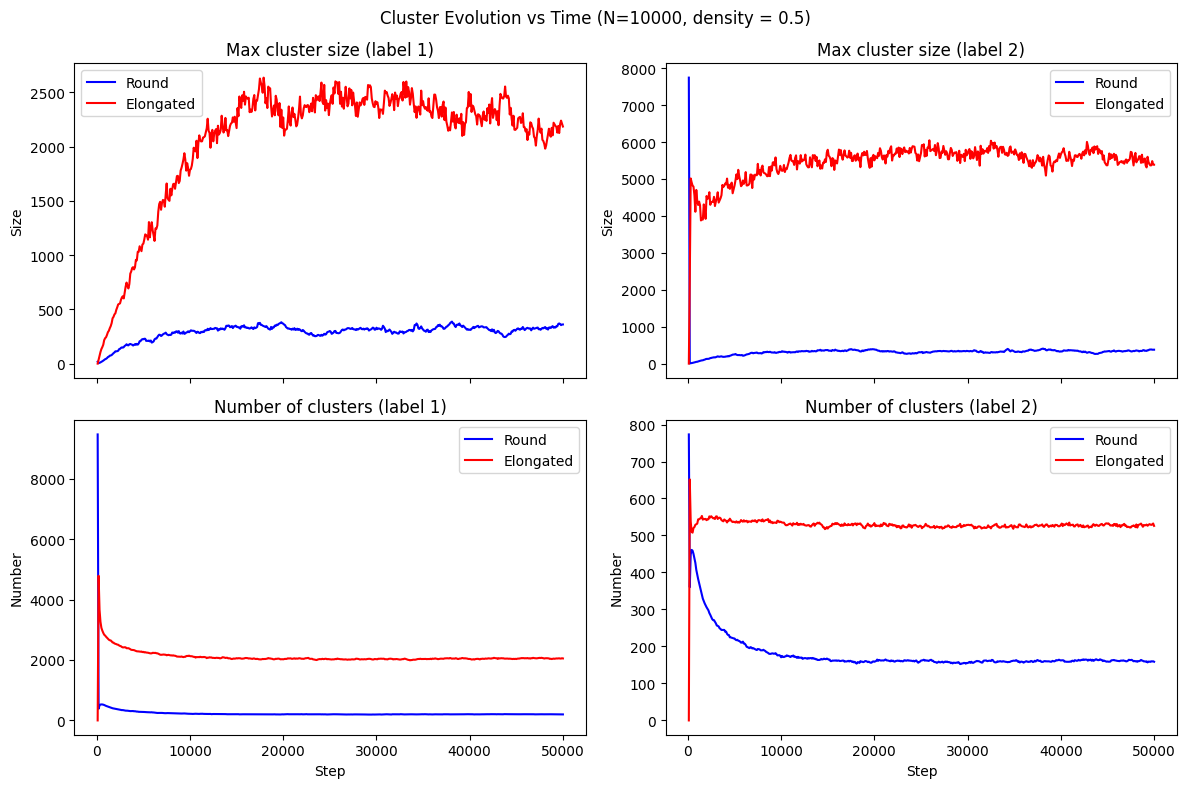

In [9]:
dens_input = input("Enter density (for example 0.50): ")
dens_nc = input("Enter number of cells (for example 10000): ")
try:
    density = float(dens_input)
    nc = int(dens_nc)
except ValueError:
    print("Error")
    exit()
df = calculate_clusters_vs_time(num_cells=nc, dens=density, max_step=max_step, step=step, rng_seed=rng_seed)
#df.to_csv("{density_folder}/clusters_vs_time.csv", index=False)
plot_cluster_evolution(df, dens=density, num_cells=nc)

### N=10_000

We can see how is the cluster evolution for each cell density in the case of N=10_000:

Last step =  50000  for density =  0.5


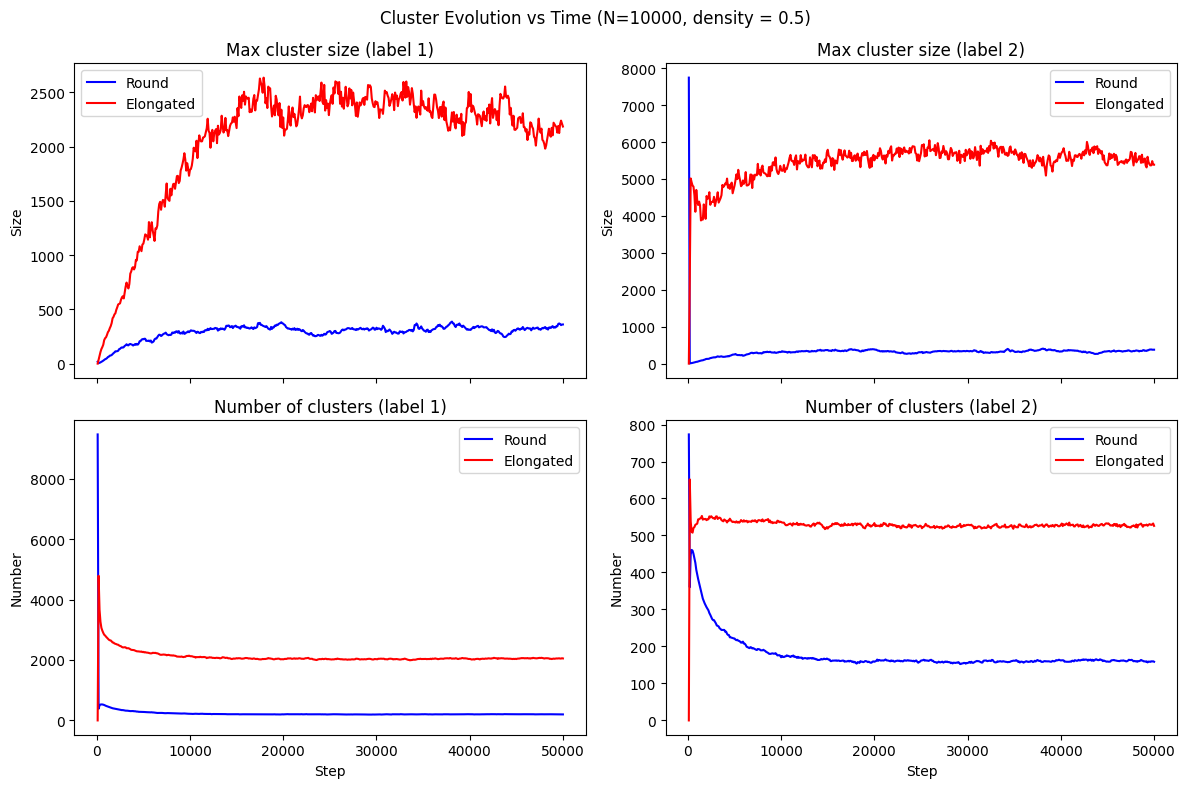

Last step =  50000  for density =  0.6


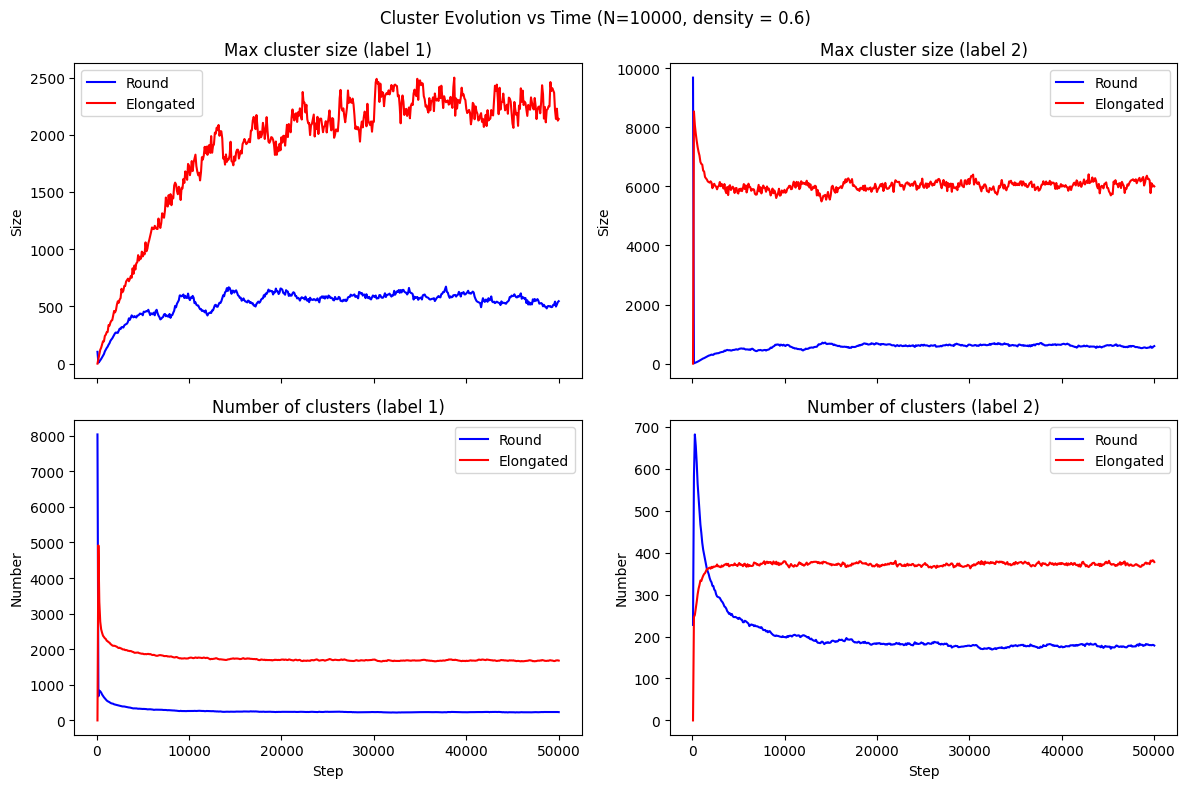

Last step =  50000  for density =  0.7


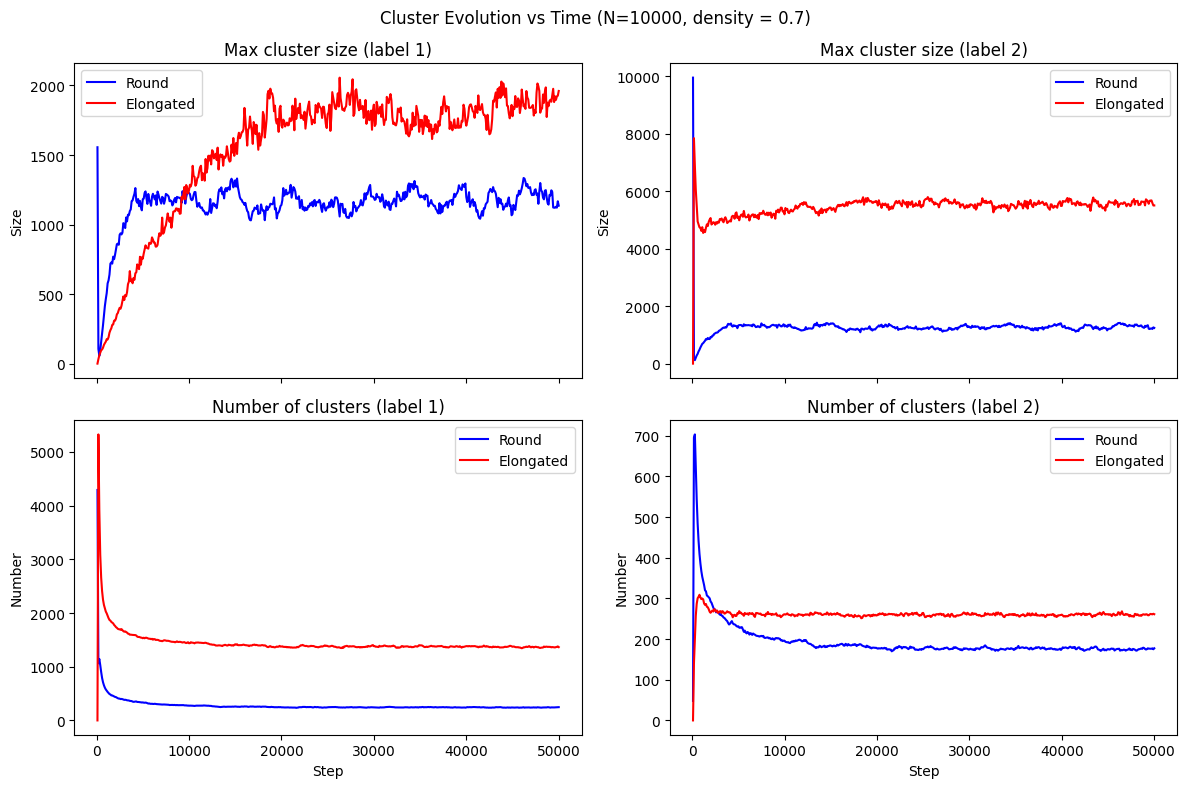

Last step =  50000  for density =  0.8


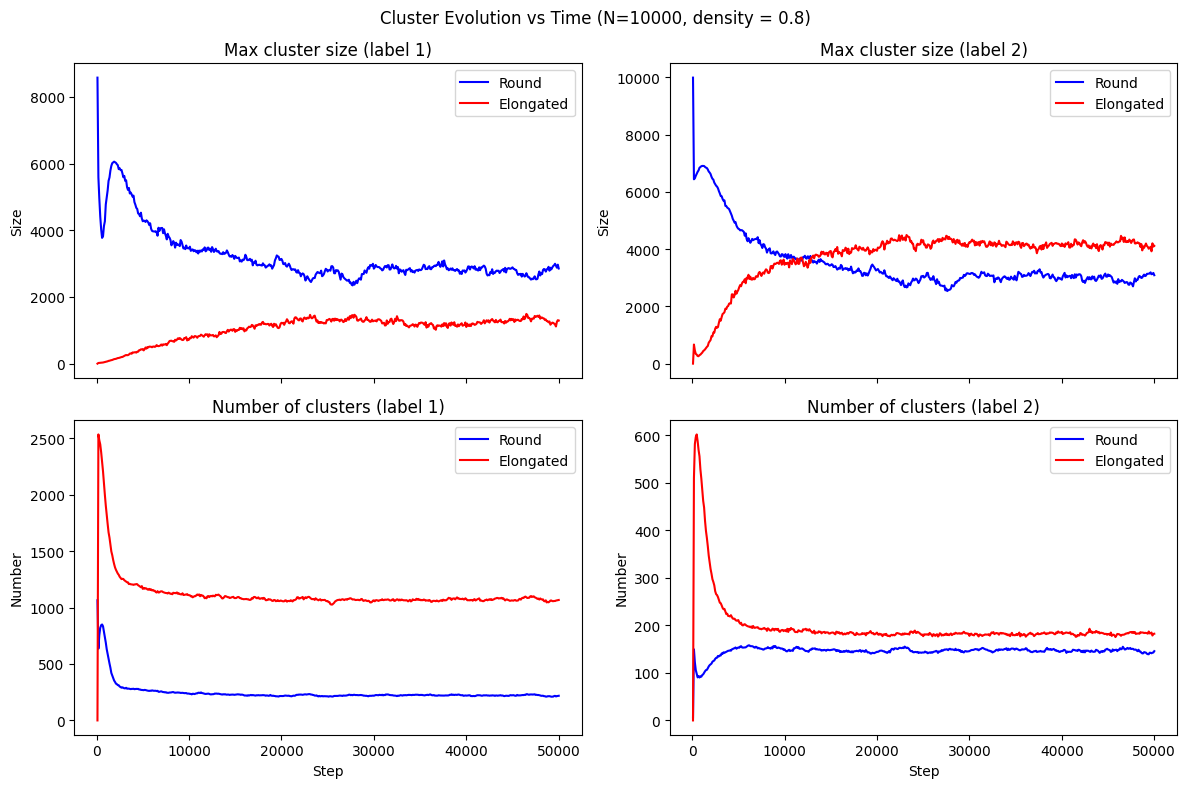

Last step =  50000  for density =  0.81


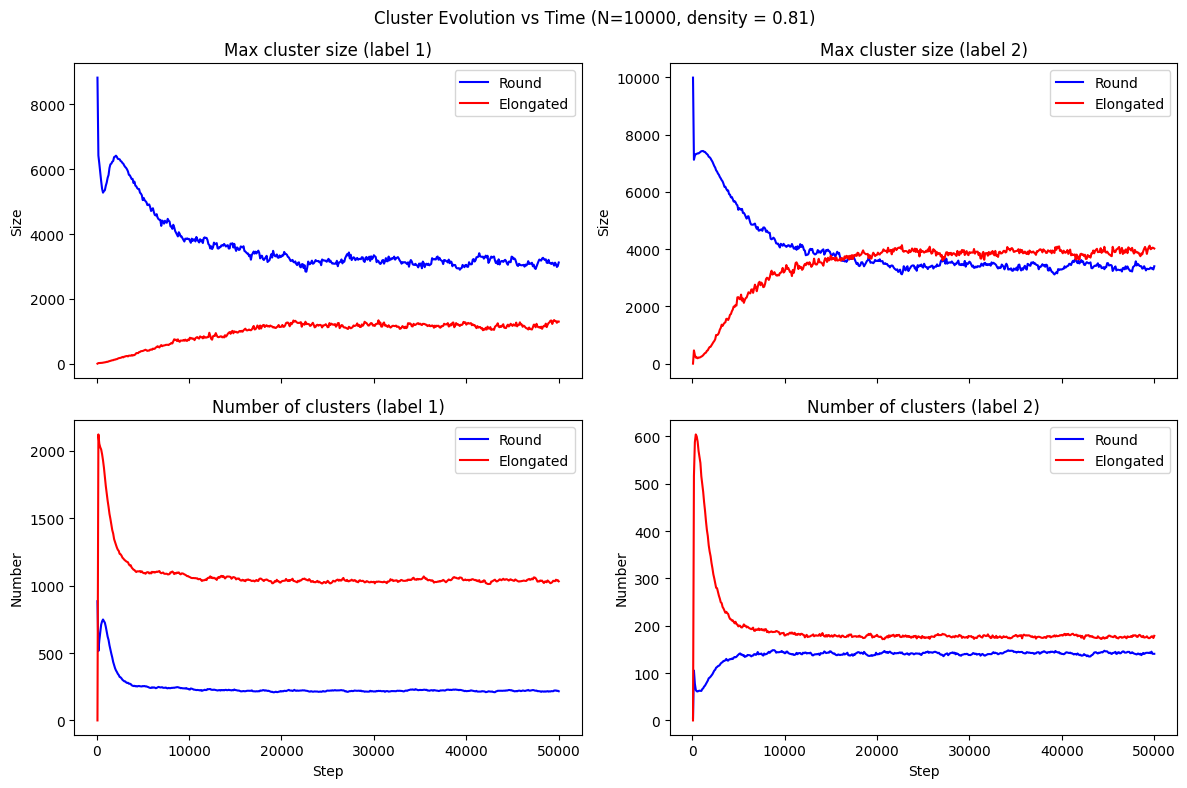

Last step =  50000  for density =  0.82


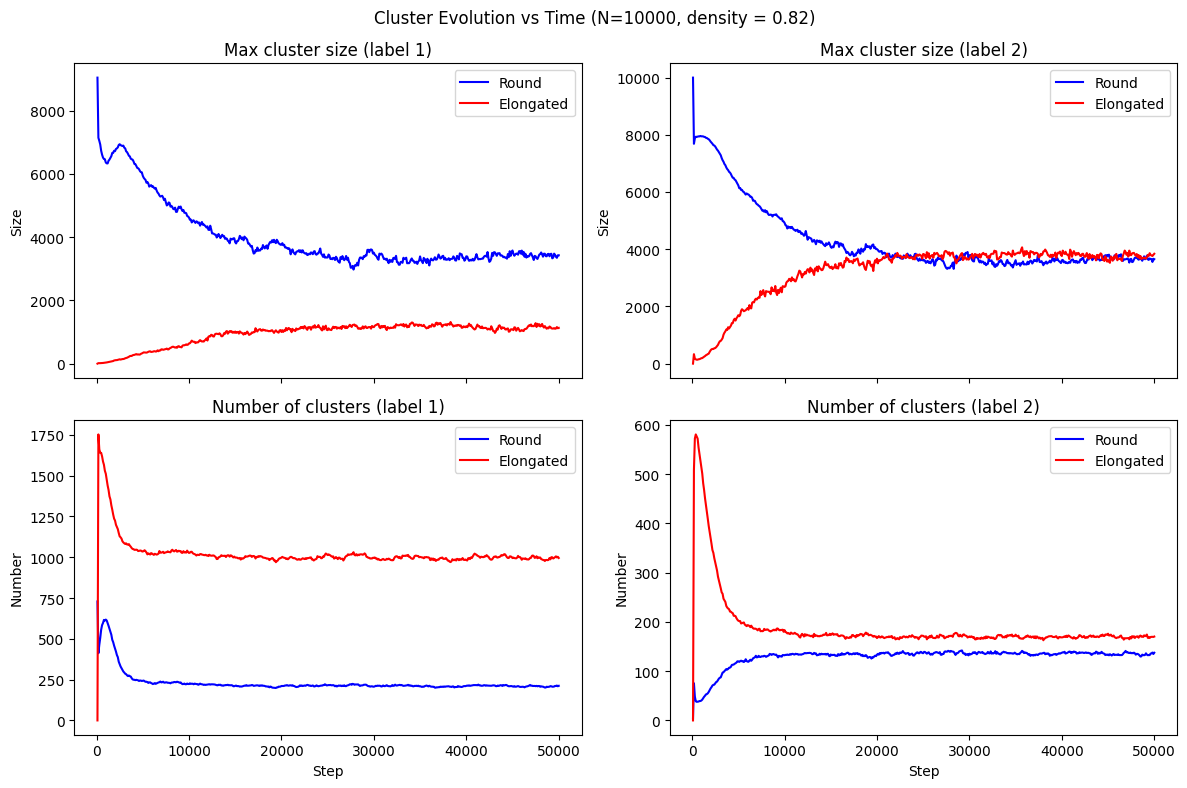

Last step =  47700  for density =  0.83


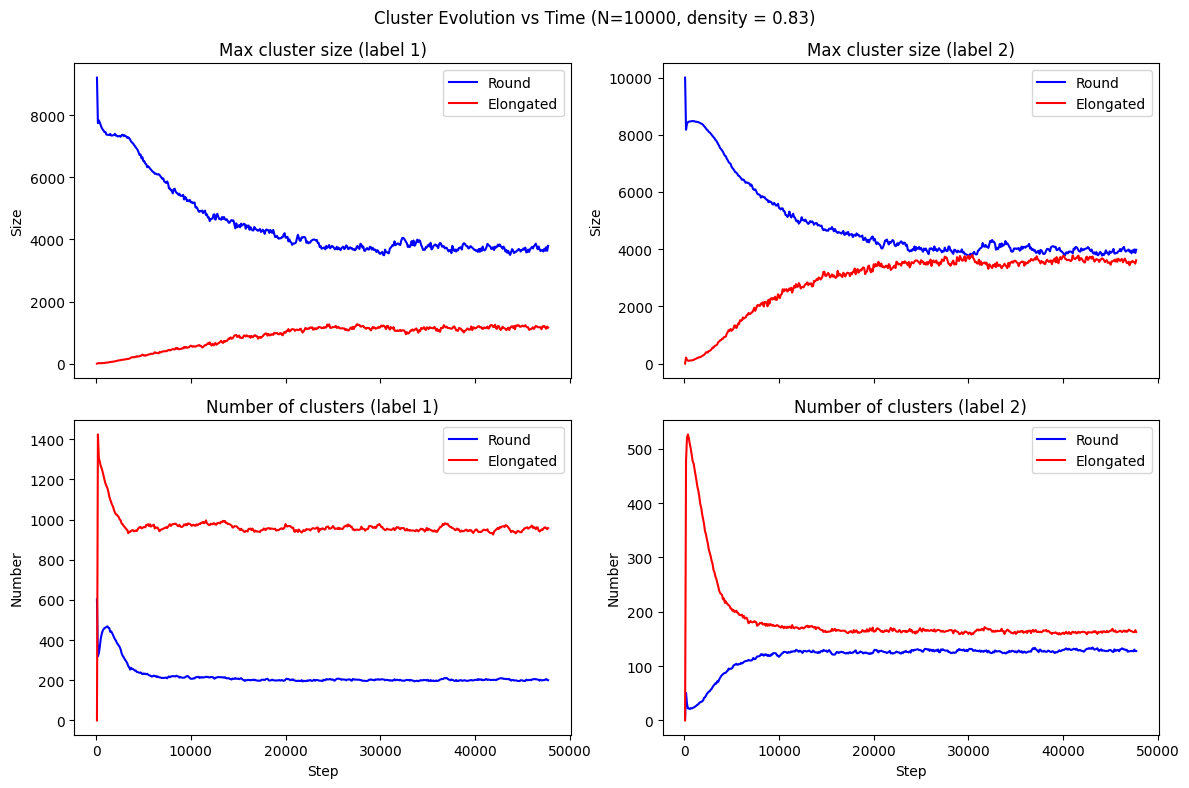

Last step =  45500  for density =  0.84


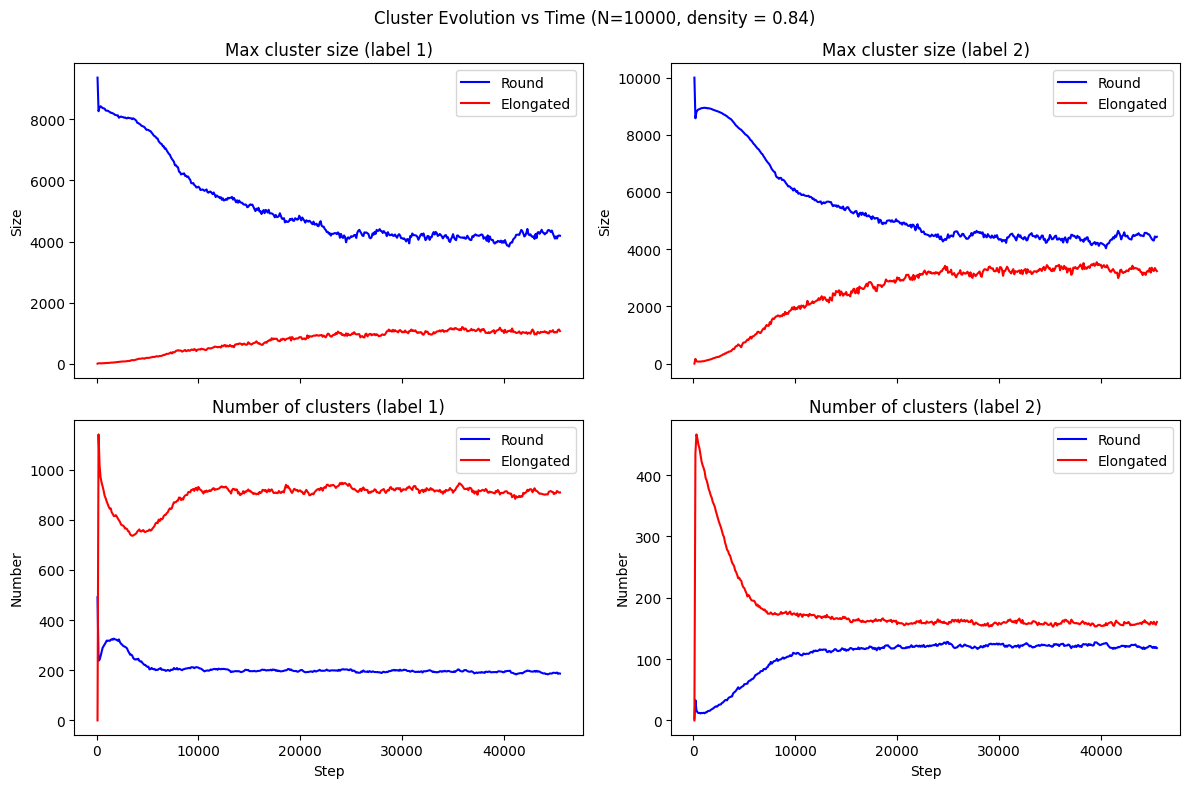

Last step =  48300  for density =  0.85


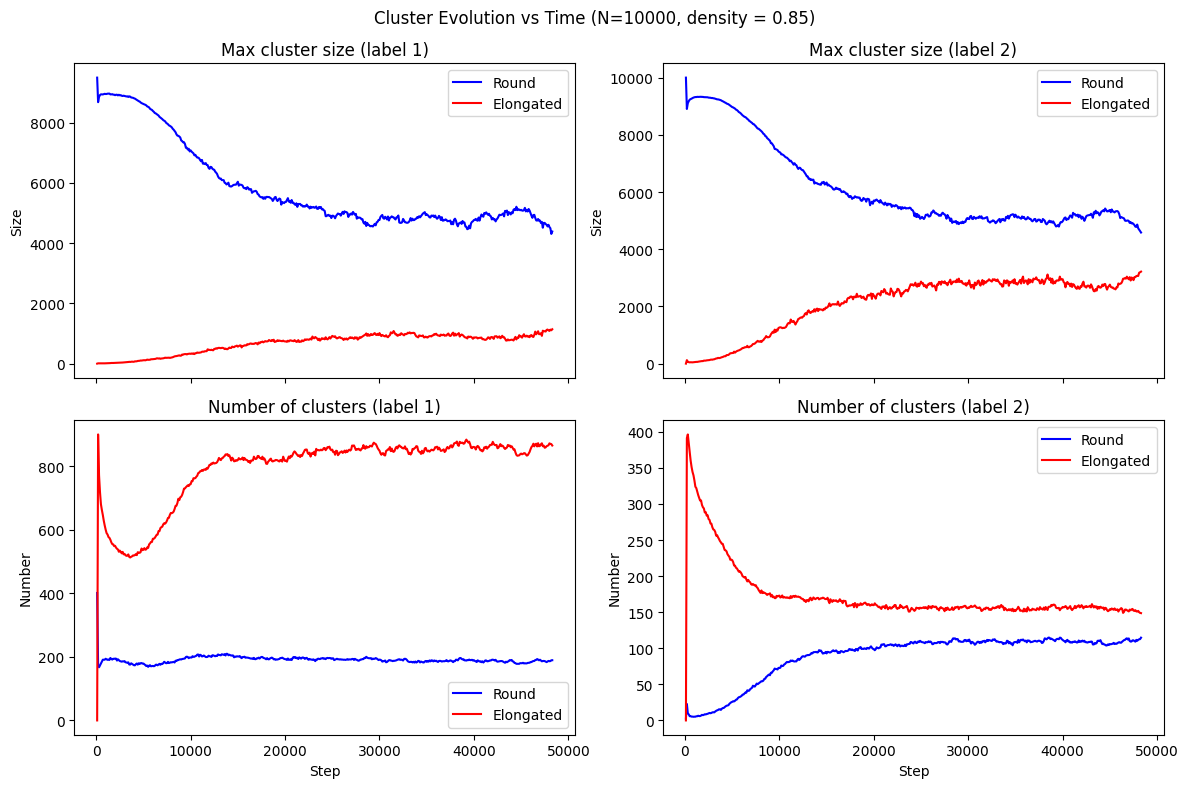

Last step =  45600  for density =  0.86


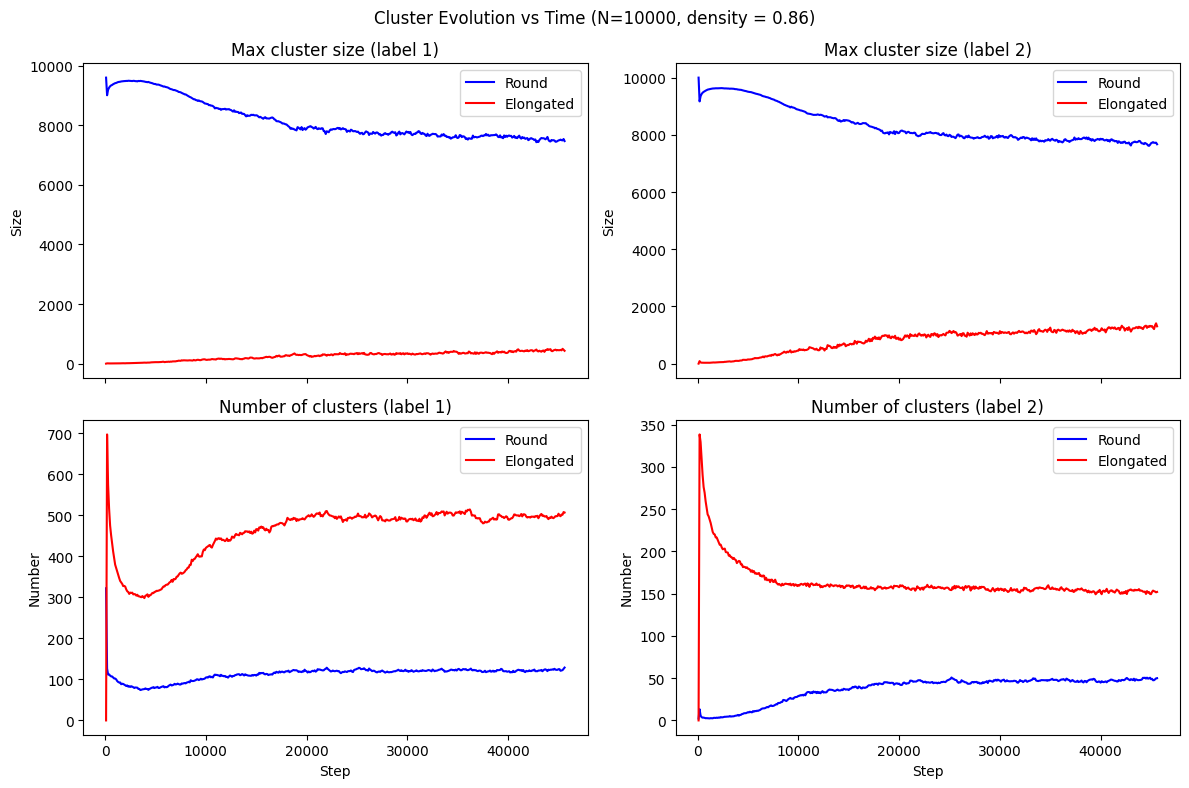

Last step =  40000  for density =  0.87


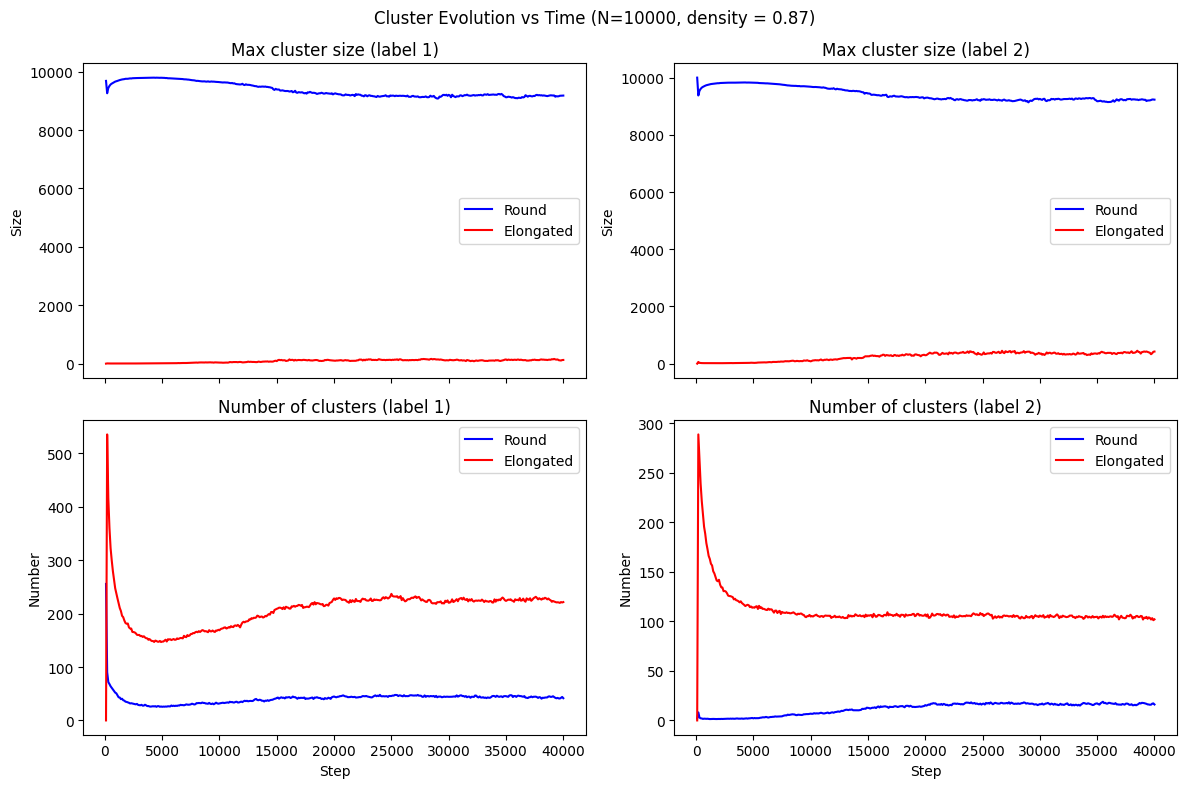

Last step =  10000  for density =  0.88


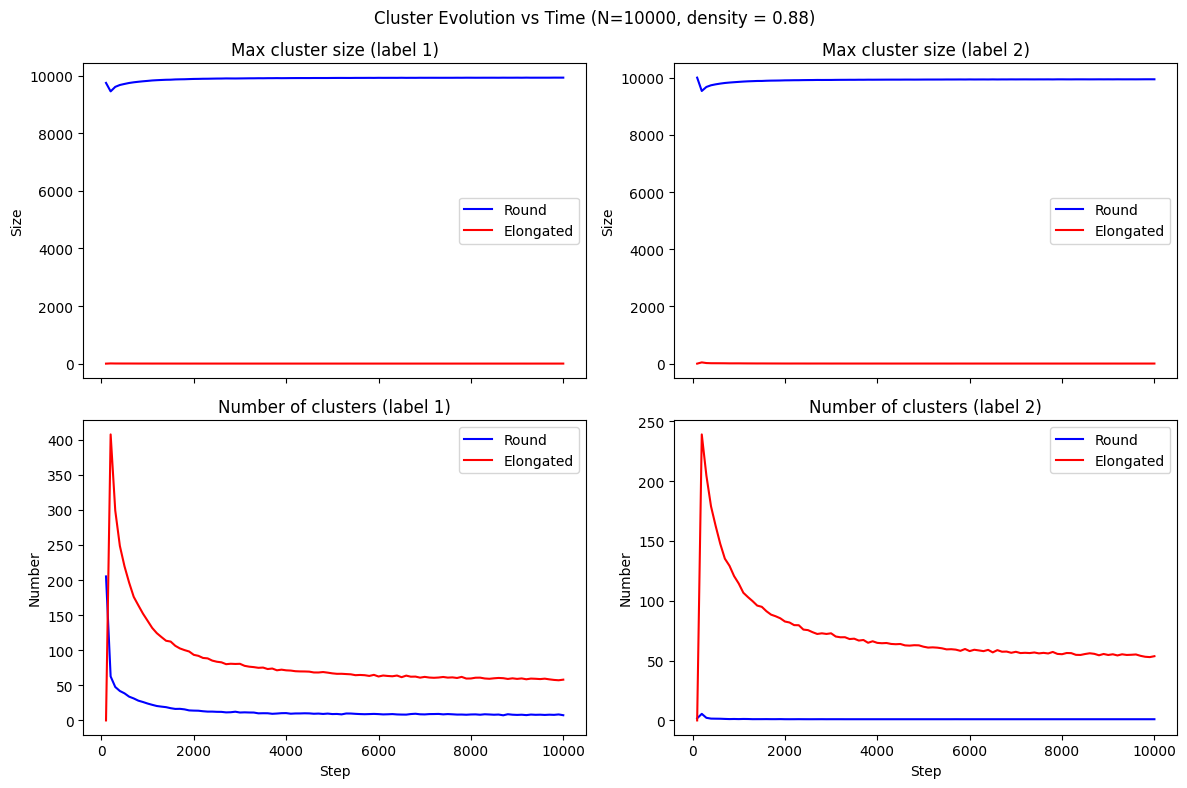

Last step =  10000  for density =  0.9


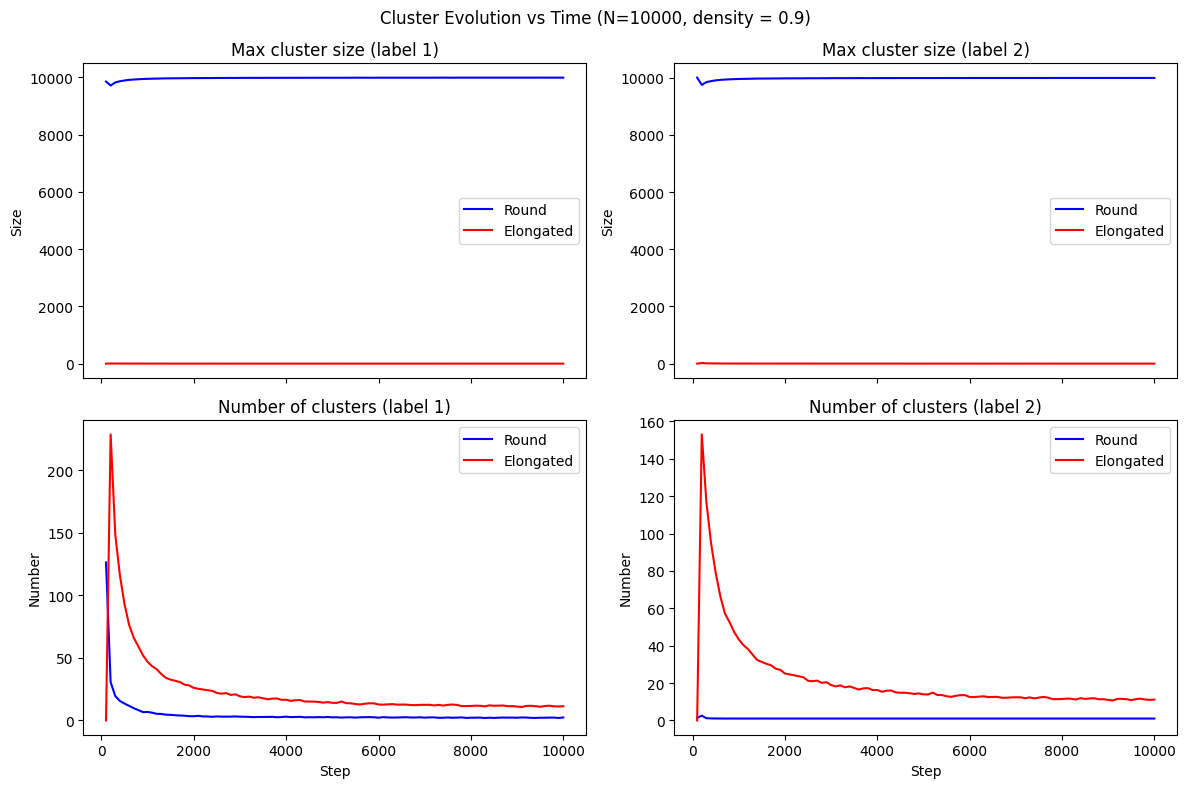

In [10]:
number_of_cells = 10_000
# Create a list with the densities
density_list = [0.5, 0.6, 0.7, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.9]
# Create a dict to save all the dataframes
dfs = {}

for density in density_list:
    # Call the function for the df in that density
    df = calculate_clusters_vs_time(num_cells=number_of_cells, dens=density, max_step=max_step, step=step, rng_seed=rng_seed)
    # df.to_csv(f"{density_folder}/clusters_vs_time_density_{density:.3f}.csv", index=False)
    # Add it to the dict
    dfs[density] = df # we can do, for example, dfs[0.85].head()
    # plot
    plot_cluster_evolution(df, dens=density, num_cells=number_of_cells)

# Steady state

In [11]:
def calculate_final_clusters(num_cells, max_step, dens, step, rng_seed):
    """
    Calculates the final number of clusters and the size of the largest cluster
    at the last time step (`max_step`) for a given density, averaging over multiple seeds.

    Parameters
    ----------
    num_cells : int
        Number of cells in the simulation.
    max_step : int
        Final time step to analyze.
    dens : float
        Cell density used in the simulation.
    step : int
        Time step interval between saved data files.
    rng_seed : list of int
        List of random seeds corresponding to different simulation runs.

    Returns
    -------
    dict
        Dictionary containing the mean and standard deviation (over seeds)
        of the number of clusters and the largest cluster size for each label type.
    """
    dens_folder = f"{dens:.3f}".replace(".", "_")
    num_cells_folder = f"N={num_cells:_}"

    # ---- Determine last valid step ----
    stop = False
    for tic in range(100, max_step, step):
        for seed in rng_seed:
            dat_actual = (
                f"data/{num_cells_folder}/{dens_folder}/dat_clusters/"
                f"clusters_culture_initial_number_of_cells={num_cells}_density={dens}_"
                f"force=Anisotropic_Grosmann_k=3.33_gamma=3_With_Noise_eta=0.033_With_Shrinking_"
                f"rng_seed={seed}_step={tic:05}.dat"
            )
            if not os.path.exists(dat_actual):
                stop = True
                break
        if stop:
            last_step = tic - step
            break
    else:
        last_step = max_step

    print(f"Last step = {last_step} for density = {dens}")

    # ---- Initialize lists ----
    number_clusters_round = []
    biggest_cluster_size_round = []
    number_clusters_elongated = []
    biggest_cluster_size_elongated = []

    number_clusters_round_2 = []
    biggest_cluster_size_round_2 = []
    number_clusters_elongated_2 = []
    biggest_cluster_size_elongated_2 = []

    # ---- Read final data for each seed ----
    for seed in rng_seed:
        dat_actual = (
            f"data/{num_cells_folder}/{dens_folder}/dat_clusters/"
            f"clusters_culture_initial_number_of_cells={num_cells}_density={dens}_"
            f"force=Anisotropic_Grosmann_k=3.33_gamma=3_With_Noise_eta=0.033_With_Shrinking_"
            f"rng_seed={seed}_step={last_step:05}.dat"
        )

        if not os.path.exists(dat_actual):
            print(f"File not found: {dat_actual}")
            continue

        df = pd.read_csv(dat_actual)

        # Extract mean per file (averaging over possible sub-measurements)
        number_clusters_round.append(df["n_round"].mean())
        biggest_cluster_size_round.append(df["max_round"].mean())
        number_clusters_elongated.append(df["n_elongated"].mean())
        biggest_cluster_size_elongated.append(df["max_elongated"].mean())

        number_clusters_round_2.append(df["n_round_2"].mean())
        biggest_cluster_size_round_2.append(df["max_round_2"].mean())
        number_clusters_elongated_2.append(df["n_elongated_2"].mean())
        biggest_cluster_size_elongated_2.append(df["max_elongated_2"].mean())

    # ---- Return dictionary with mean/std over seeds ----
    return {
        "mean": {
            "N_round": np.mean(number_clusters_round),
            "MAX_round": np.mean(biggest_cluster_size_round),
            "N_elongated": np.mean(number_clusters_elongated),
            "MAX_elongated": np.mean(biggest_cluster_size_elongated),
            "N_round_2": np.mean(number_clusters_round_2),
            "MAX_round_2": np.mean(biggest_cluster_size_round_2),
            "N_elongated_2": np.mean(number_clusters_elongated_2),
            "MAX_elongated_2": np.mean(biggest_cluster_size_elongated_2),
        },
        "std": {
            "N_round": np.std(number_clusters_round),
            "MAX_round": np.std(biggest_cluster_size_round),
            "N_elongated": np.std(number_clusters_elongated),
            "MAX_elongated": np.std(biggest_cluster_size_elongated),
            "N_round_2": np.std(number_clusters_round_2),
            "MAX_round_2": np.std(biggest_cluster_size_round_2),
            "N_elongated_2": np.std(number_clusters_elongated_2),
            "MAX_elongated_2": np.std(biggest_cluster_size_elongated_2),
        },
        "last_step": last_step,
    }

In [12]:
def plot_clusters_vs_density(df_mean, error_bars, num_cells, output_path, title):
    """
    Plots the mean largest cluster size and mean number of clusters vs density
    for both round and elongated cells.

    Parameters
    ----------
    df_mean : pandas.DataFrame
        DataFrame with mean values for each density.
    error_bars : pandas.DataFrame
        DataFrame with standard errors for each density.
    num_cells : int
        Total number of cells in the simulation.
    output_path : str
        Path to save the figure.
    title : str
        Figure title.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
    plt.subplots_adjust(wspace=0.3)

    color_round = "blue"
    color_elong = "red"

    # Left: largest cluster size (normalized)
    axes[0].errorbar(
        df_mean["density"], df_mean["largest_cluster_round"], 
        yerr=error_bars["largest_cluster_round_std"], 
        fmt='o-', color=color_round, label="Round"
    )
    axes[0].errorbar(
        df_mean["density"], df_mean["largest_cluster_elongated"], 
        yerr=error_bars["largest_cluster_elongated_std"], 
        fmt='o-', color=color_elong, label="Elongated"
    )
    axes[0].set_xlabel("Density ρ")
    axes[0].set_ylabel("Largest cluster size / N")
    axes[0].set_title("Normalized largest cluster size")
    axes[0].legend()

    # Right: number of clusters
    axes[1].errorbar(
        df_mean["density"], df_mean["num_clusters_round"], 
        yerr=error_bars["num_clusters_round_std"], 
        fmt='o-', color=color_round, label="Round"
    )
    axes[1].errorbar(
        df_mean["density"], df_mean["num_clusters_elongated"], 
        yerr=error_bars["num_clusters_elongated_std"], 
        fmt='o-', color=color_elong, label="Elongated"
    )
    axes[1].set_xlabel("Density ρ")
    axes[1].set_ylabel("Number of clusters")
    axes[1].set_title("Mean number of clusters")
    axes[1].legend()

    fig.suptitle(title)
    plt.savefig(output_path, dpi=600)
    plt.show()
    plt.close()

Last step = 50000 for density = 0.5
Last step = 50000 for density = 0.6
Last step = 50000 for density = 0.7
Last step = 50000 for density = 0.8
Last step = 50000 for density = 0.81
Last step = 50000 for density = 0.82
Last step = 47700 for density = 0.83
Last step = 45500 for density = 0.84
Last step = 48300 for density = 0.85
Last step = 45600 for density = 0.86
Last step = 40000 for density = 0.87
Last step = 10000 for density = 0.88
Last step = 10000 for density = 0.9


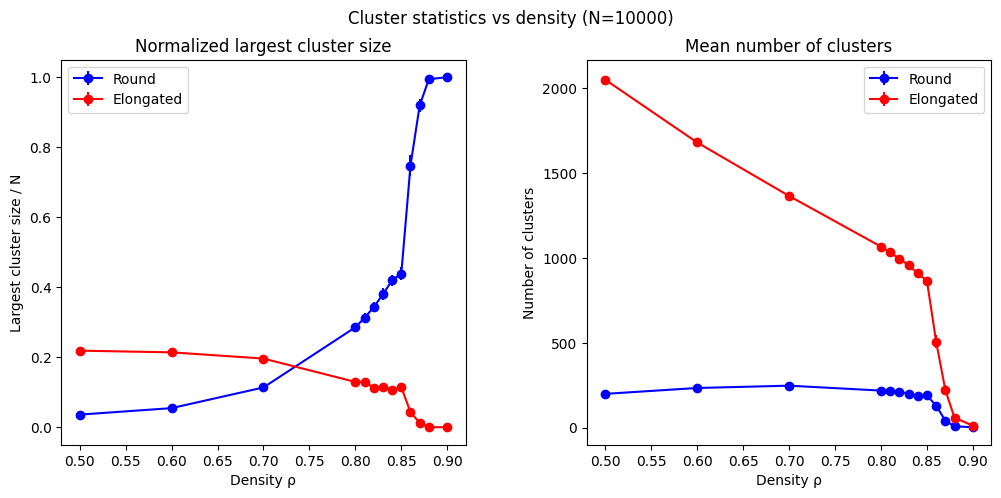

In [15]:
number_of_cells = 10_000
density_list = [0.5, 0.6, 0.7, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.9]
number_of_realizations = len(rng_seed)

df_mean = pd.DataFrame(columns=[
    "density",
    "largest_cluster_round",
    "largest_cluster_elongated",
    "num_clusters_round",
    "num_clusters_elongated"
])

df_std = pd.DataFrame(columns=[
    "density",
    "largest_cluster_round_std",
    "largest_cluster_elongated_std",
    "num_clusters_round_std",
    "num_clusters_elongated_std"
])

for dens in density_list:
    result = calculate_final_clusters(number_of_cells, max_step, dens, step, rng_seed)
    mean, std = result["mean"], result["std"]

    df_mean.loc[len(df_mean)] = [
        dens,
        mean["MAX_round"] / number_of_cells,
        mean["MAX_elongated"] / number_of_cells,
        mean["N_round"],
        mean["N_elongated"],
    ]
    df_std.loc[len(df_std)] = [
        dens,
        std["MAX_round"] / number_of_cells,
        std["MAX_elongated"] / number_of_cells,
        std["N_round"],
        std["N_elongated"],
    ]

error_bars = df_std / np.sqrt(number_of_realizations)

num_cells_folder = f"N={number_of_cells:_}"
folder_path = f"graphs/{num_cells_folder}/clusters/cluster_vs_density"
os.makedirs(folder_path, exist_ok=True)

plot_clusters_vs_density(
    df_mean=df_mean,
    error_bars=error_bars,
    num_cells=number_of_cells,
    output_path=f"{folder_path}/cluster_vs_density_N={number_of_cells}.png",
    title=f"Cluster statistics vs density (N={number_of_cells})"
)

# Final cluster distribution

Now we have a csv with all the sizes seen for every seed in the last step for a given density. Let's do a function to plot the distribution.

In [16]:
def log_hist(ax, data, color, label, alpha=0.7):
    """
    Adds a histogram with logarithmically spaced bins to a given axis.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axis object where the histogram will be plotted.
    data : pandas.Series or array-like
        Input data to be plotted.
    color : str
        Color of the histogram bars.
    label : str
        Label for the histogram (used in the legend).
    alpha : float, optional
        Opacity of the histogram bars, by default 0.7.
    """
    data = np.array(data.dropna())
    if len(data) == 0:
        return

    bins = np.logspace(np.log10(data.min()), np.log10(data.max()), 20)
    ax.hist(data, bins=bins, color=color, alpha=alpha, label=label)

def plot_cluster_size_distribution(density, num_cells):
    """
    Plots and saves the final cluster size distribution for round and elongated cells.

    Two histograms are shown (label 1 and label 2), each distinguishing between round
    and elongated cells. Both axes use logarithmic binning and scales.

    Parameters
    ----------
    density : float
        Cell density.
    num_cells : int
        Number of cells in the simulation.
    """
    dens_folder = f"{density:.3f}".replace(".", "_")
    num_cells_folder = f"N={num_cells:_}"
    input_file = f"data/{num_cells_folder}/{dens_folder}/cluster_distributions_final/cluster_size_distribution_cells={num_cells}_density={density:.3f}.csv"

    if not os.path.exists(input_file):
        print(f"File not found: {input_file}")
        return

    # Create the folder to save the figure
    output_dir = f"graphs/{num_cells_folder}/clusters/cluster_size_distribution"
    os.makedirs(output_dir, exist_ok=True)

    # Read the data
    df = pd.read_csv(input_file)

    # Create the figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # First plot, label 1
    log_hist(axes[0], df['sizes_elongated'], color='tomato', label='Elongated', alpha=0.9)
    log_hist(axes[0], df['sizes_round'], color='skyblue', label='Round', alpha=0.7)
    axes[0].set_title(f'Label 1 — N={num_cells}, density {density}')
    axes[0].set_xscale('log')
    axes[0].set_yscale('log')
    axes[0].set_xlabel('Cluster size')
    axes[0].set_ylabel('Count')
    axes[0].legend()

    # Second plot, label 2
    log_hist(axes[1], df['sizes_elongated_2'], color='tomato', label='Elongated', alpha=0.9)
    log_hist(axes[1], df['sizes_round_2'], color='skyblue', label='Round', alpha=0.7)
    axes[1].set_title(f'Label 2 — N={num_cells}, density {density}')
    axes[1].set_xscale('log')
    axes[1].set_yscale('log')
    axes[1].set_xlabel('Cluster size')
    axes[1].legend()

    # Save
    plt.tight_layout()
    output_path = f"{output_dir}/cluster_size_distribution_N={num_cells}_density={density:.3f}.png"
    plt.savefig(output_path, dpi=600)
    plt.show()
    plt.close()

### Particular density and number of cells

In the case we want to see only one particular density and number of cells, continue as follows.

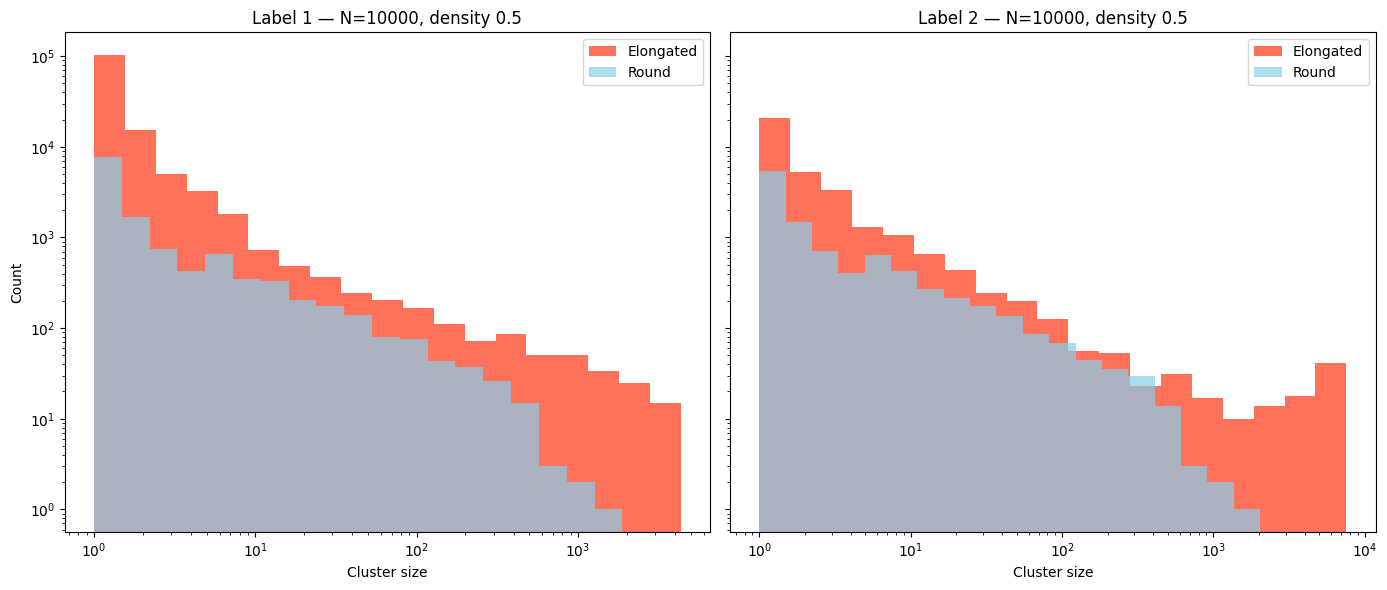

In [18]:
dens_input = input("Enter density (for example 0.50): ")
nc_input = input("Enter number of cells (for example 10000): ")
try:
    density = float(dens_input)
    nc = int(nc_input)
except ValueError:
    print("Error")
    exit()
plot_cluster_size_distribution(density=density, num_cells=nc)

### N=10_000

We can see how is the clusters distribution for each density in the case of N=10_000.

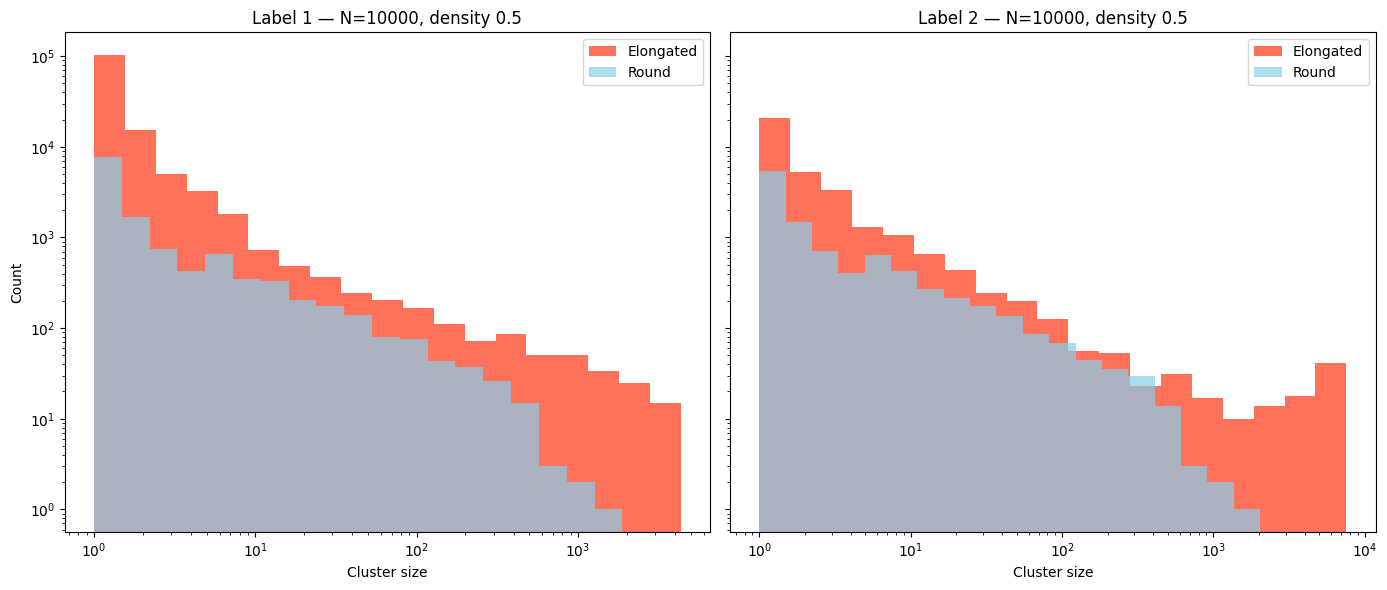

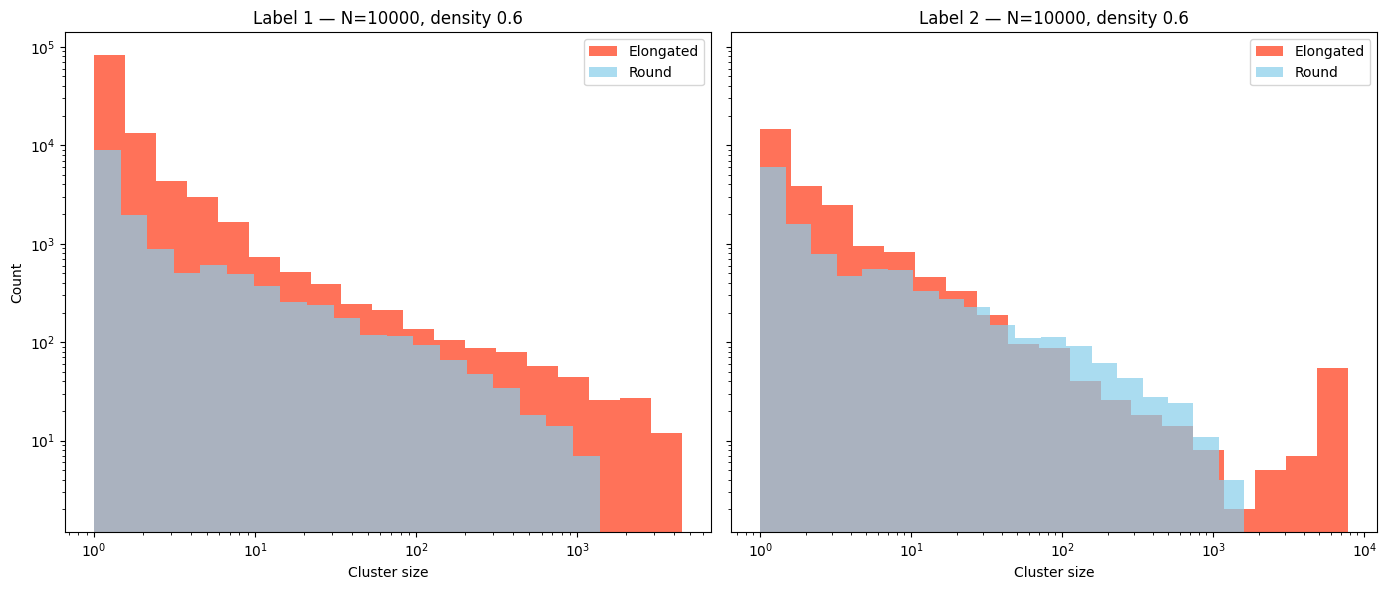

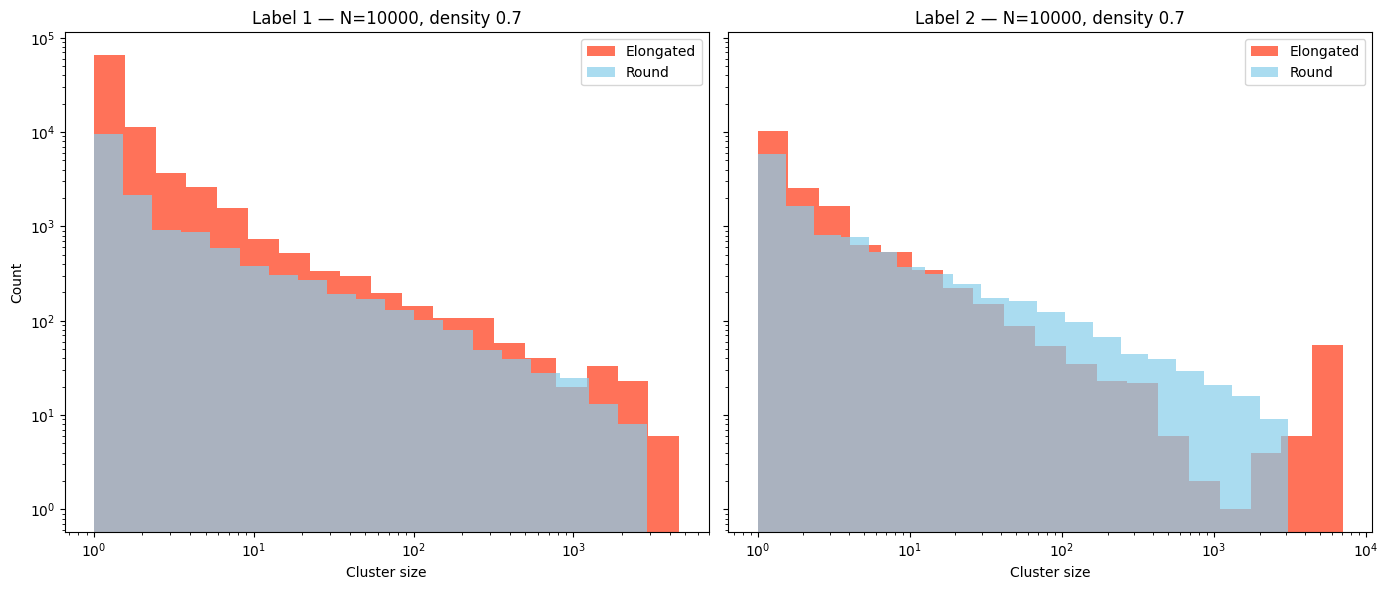

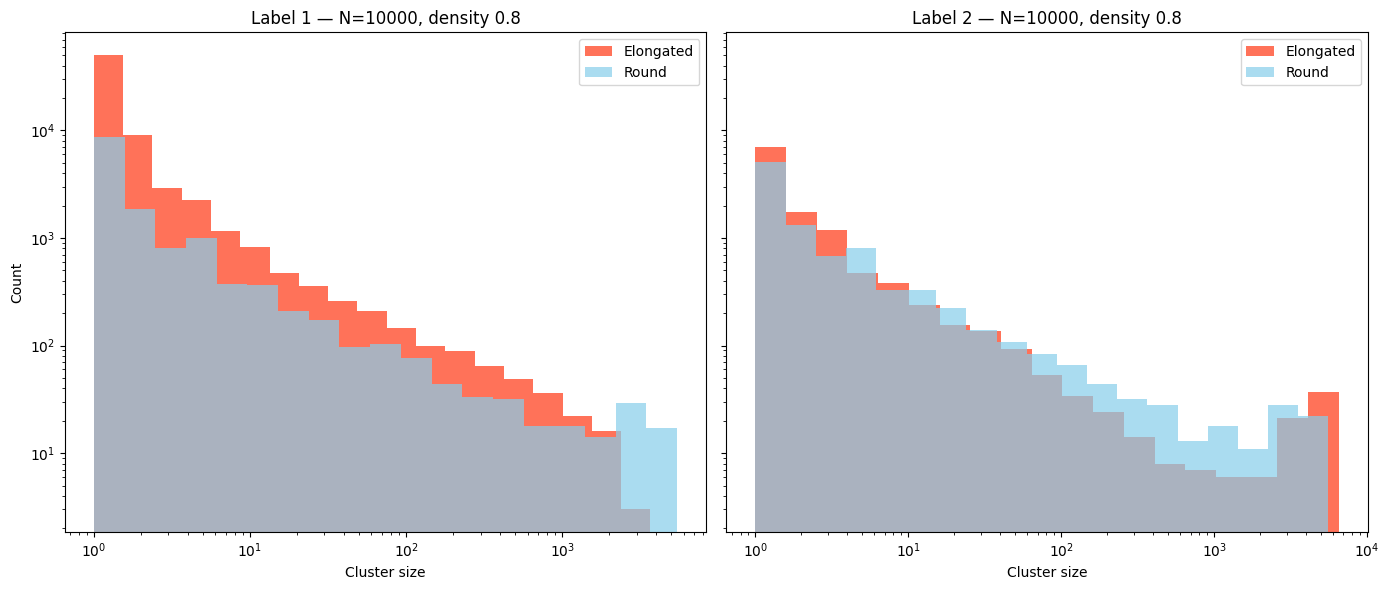

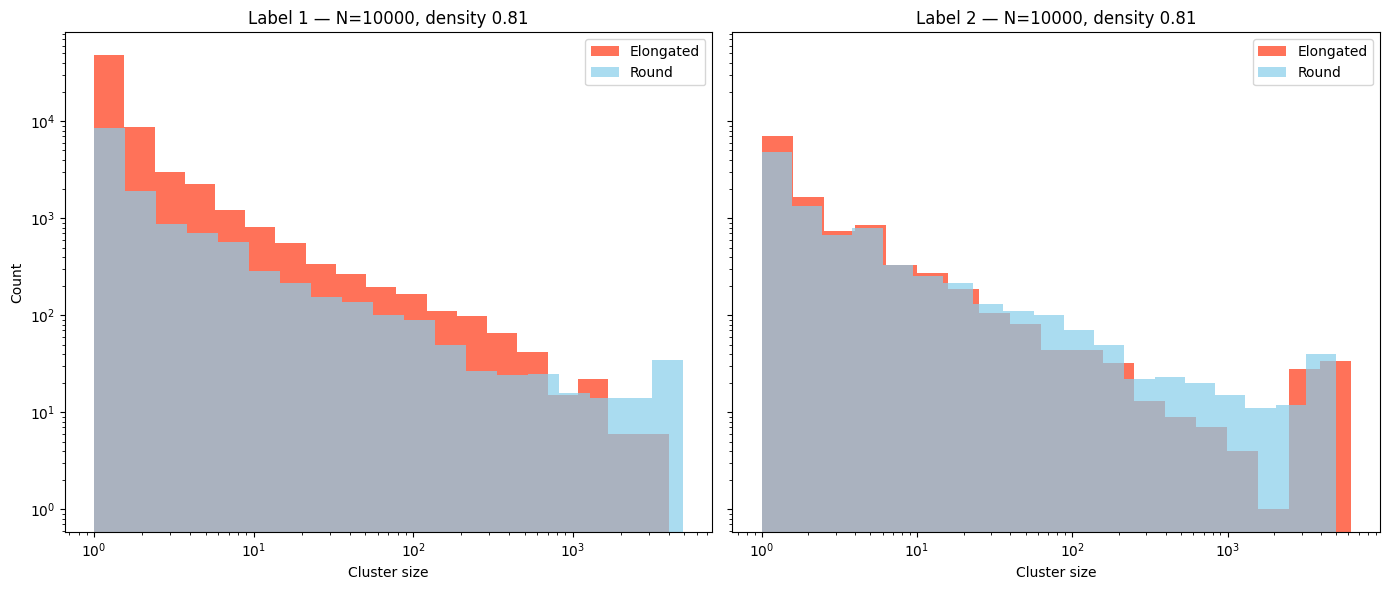

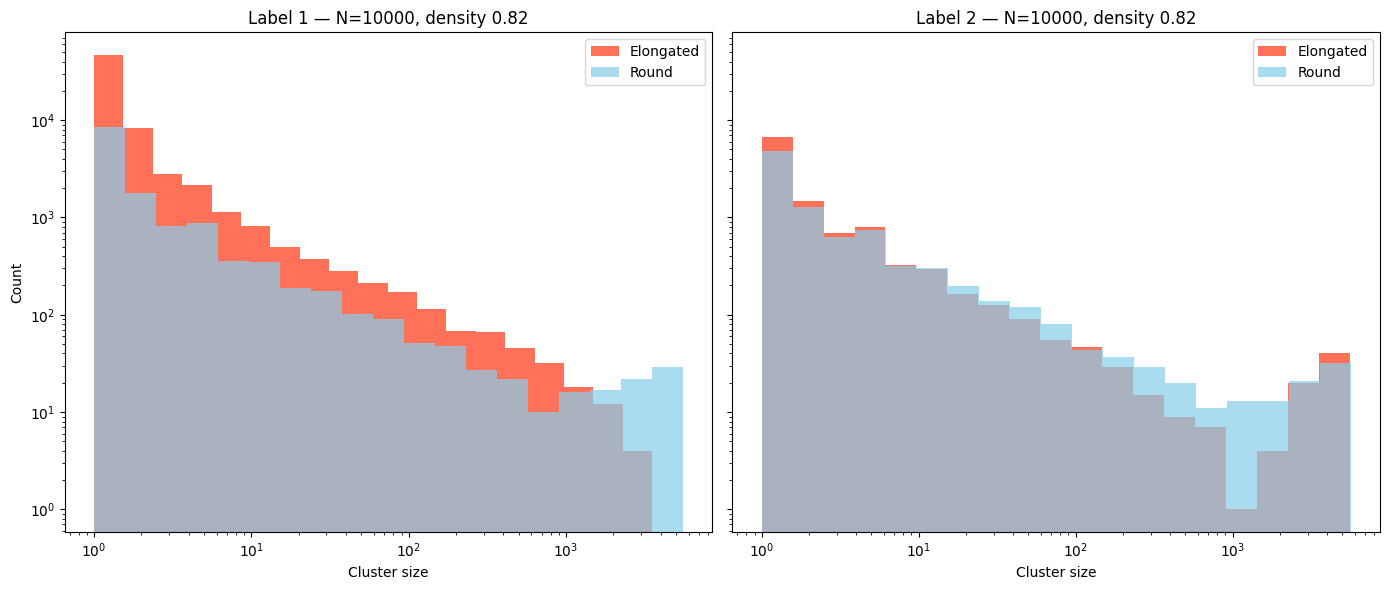

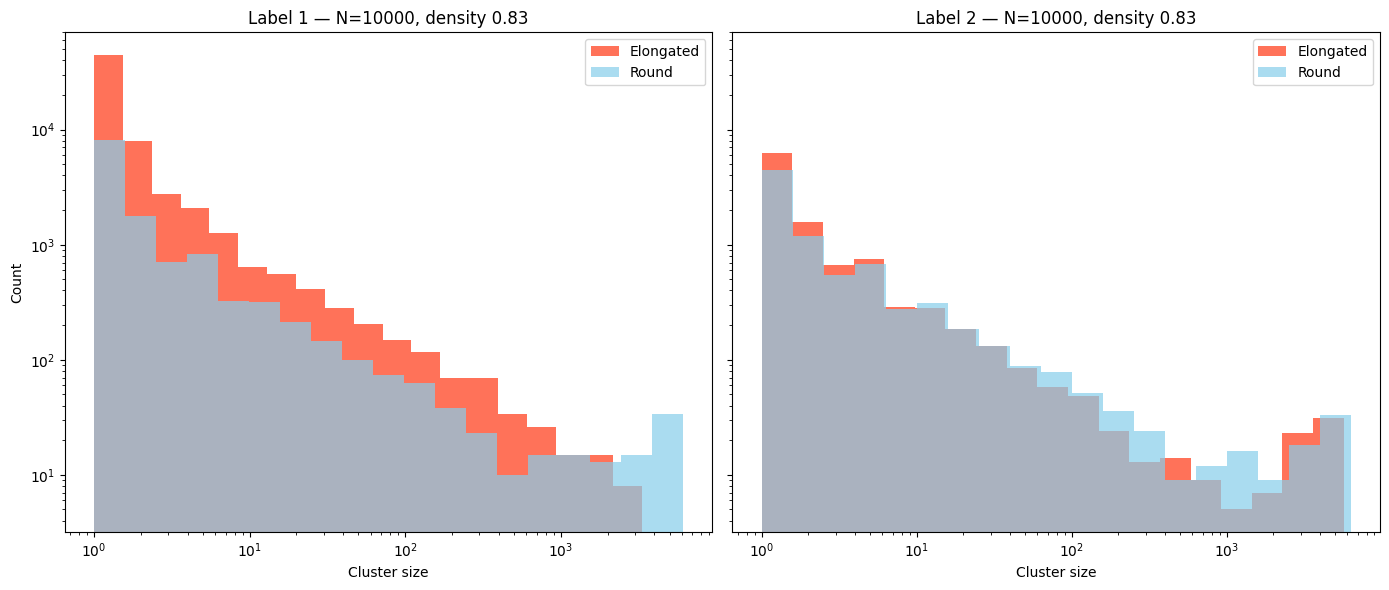

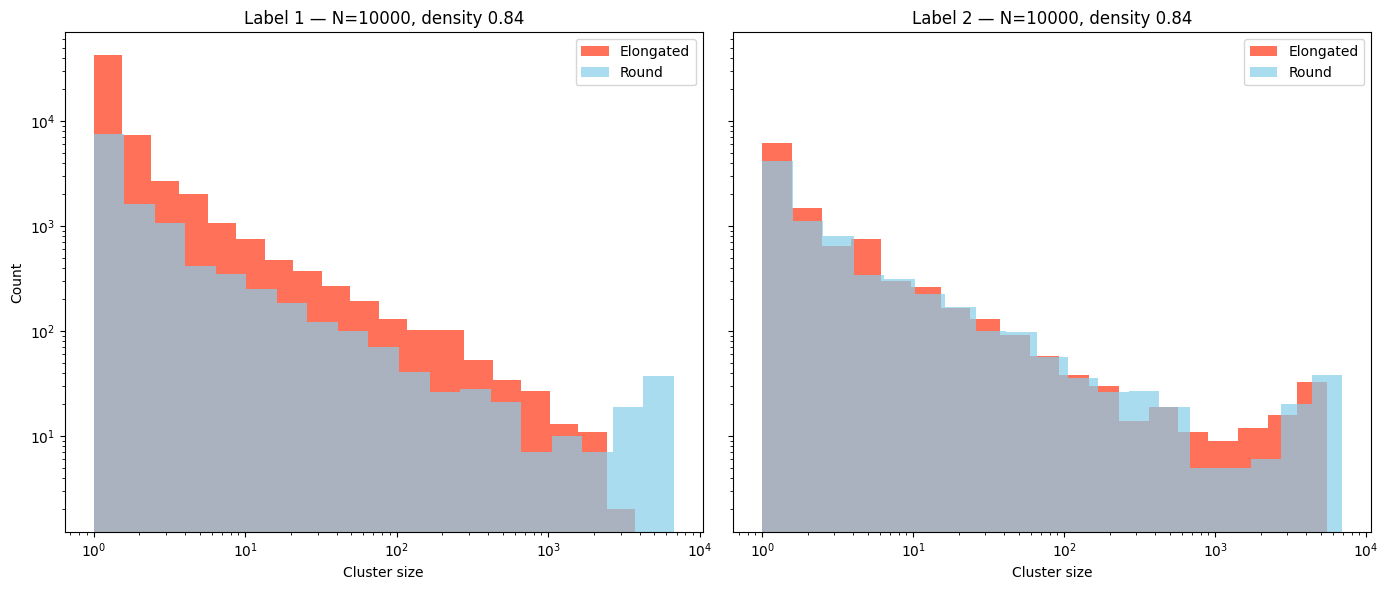

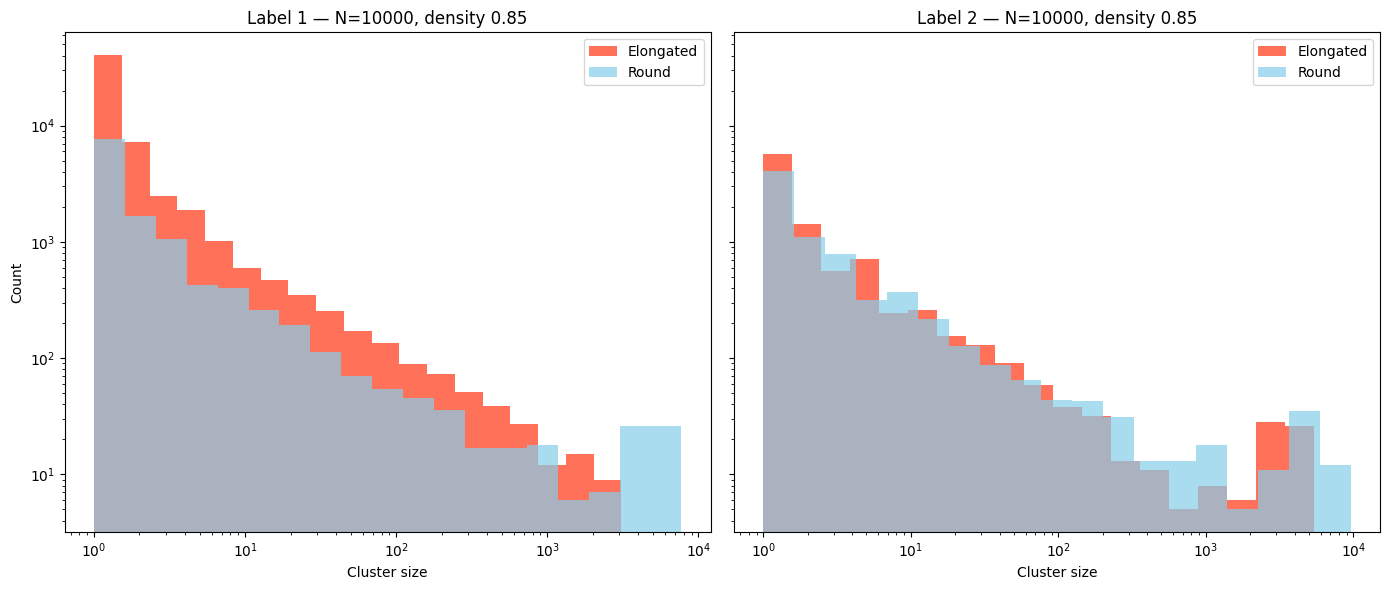

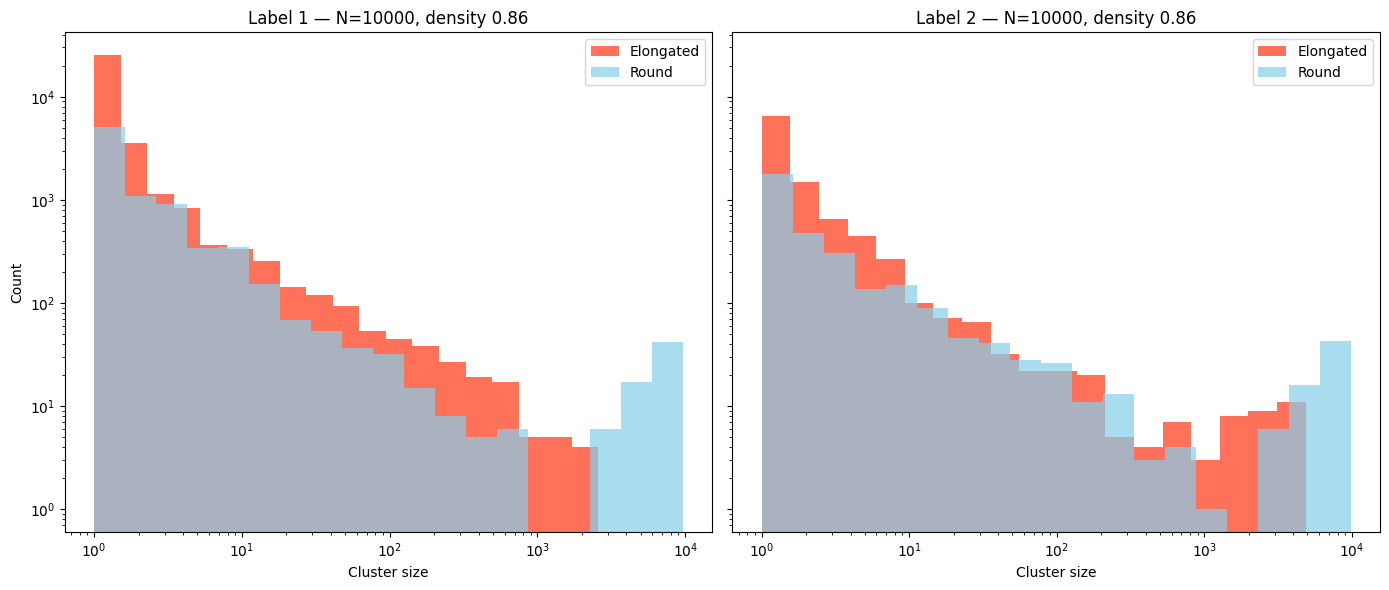

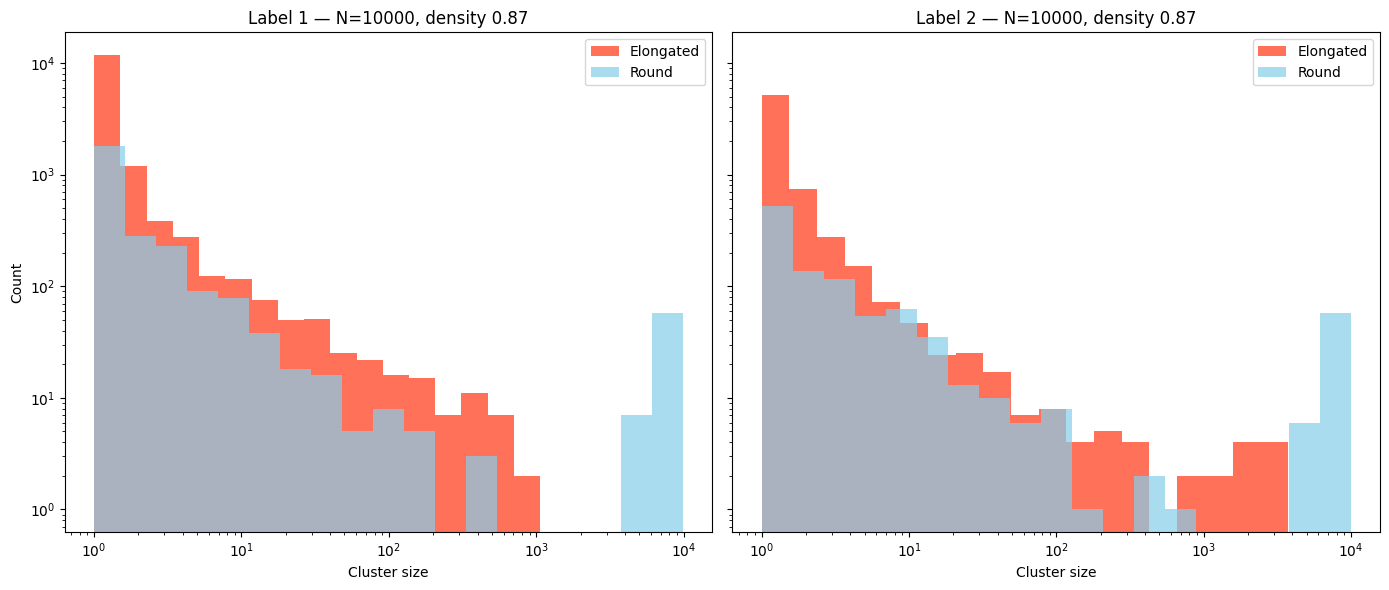

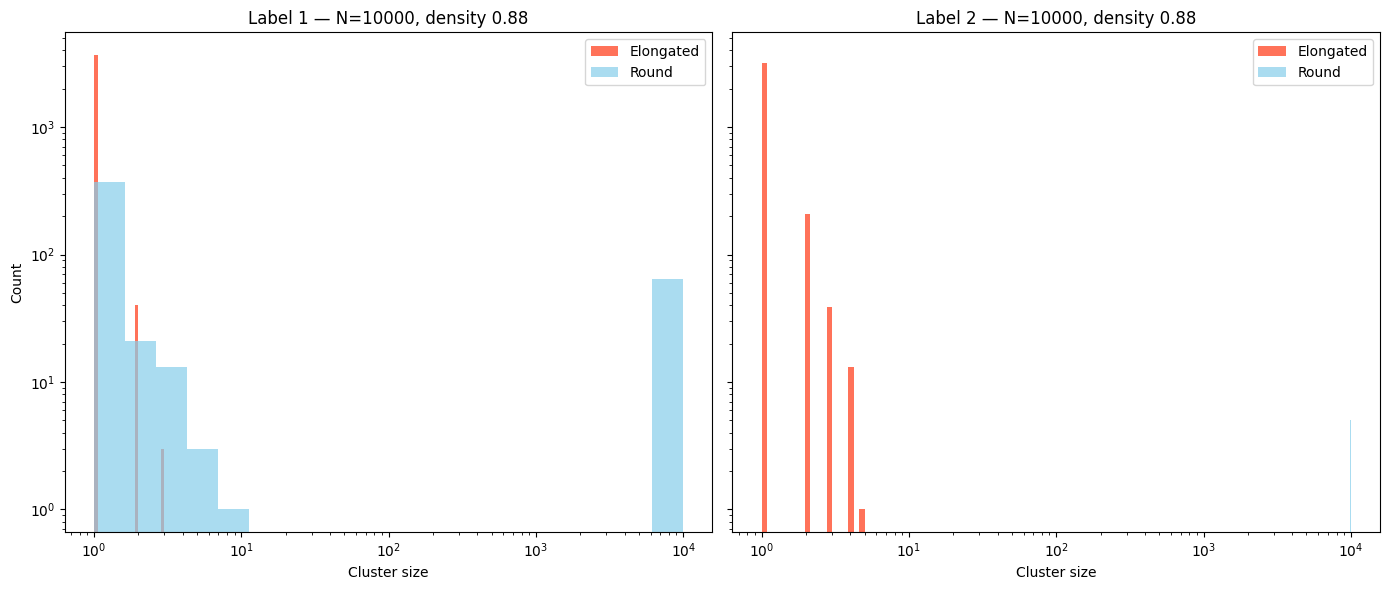

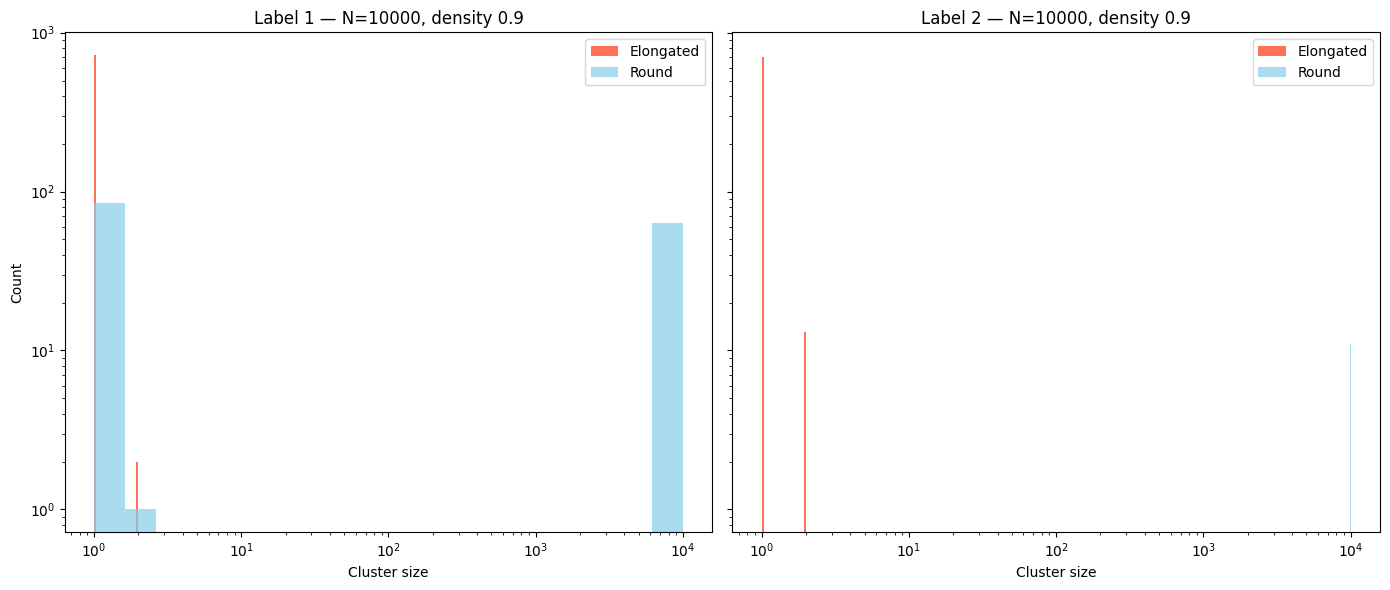

In [19]:
number_of_cells = 10_000
# Create a list with the densities
density_list = [0.5, 0.6, 0.7, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.9]

for d in density_list:
    # plot
    plot_cluster_size_distribution(density=d, num_cells=number_of_cells)

In [30]:
def log_hist_line(ax, data, num_cells, color, label, lw=2):
    """
    Plot a logarithmic-binned histogram as a smooth line (normalized by total number of cells).

    Parameters
    ----------
    ax : matplotlib axis
    data : array-like
        Cluster sizes (already filtered by phenotype)
    num_cells : int
        Total number of cells (for normalization)
    color : str
    label : str
    lw : float
    """
    data = np.array(data.dropna())
    if len(data) == 0:
        return

    # Logarithmic bins
    bins = np.logspace(np.log10(data.min()), np.log10(data.max()), 20)
    counts, edges = np.histogram(data, bins=bins)

    # Normalize by total number of cells
    counts = counts / num_cells

    # Geometric mean for log bins
    bin_centers = np.sqrt(edges[:-1] * edges[1:])

    ax.plot(bin_centers, counts, color=color, lw=lw, label=label)


def plot_relative_cluster_size_distribution(densities, num_cells, colors=None):
    """
    Plots the cluster size distribution normalized by total number of cells,
    for elongated and round phenotypes separately.

    Y-axis: (number of clusters of size S) / (total number of cells)
    X-axis: cluster size S (in linear or log scale)
    """
    if colors is None:
        colors = plt.cm.plasma(np.linspace(0, 1, len(densities)))

    num_cells_folder = f"N={num_cells:_}"

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    for dens, color in zip(densities, colors):
        dens_folder = f"{dens:.3f}".replace(".", "_")
        input_file = (
            f"data/{num_cells_folder}/{dens_folder}/cluster_distributions_final/"
            f"cluster_size_distribution_cells={num_cells}_density={dens:.3f}.csv"
        )

        if not os.path.exists(input_file):
            print(f"File not found: {input_file}")
            continue

        df = pd.read_csv(input_file)

        sizes_elongated = df['sizes_elongated']
        sizes_round = df['sizes_round']

        # Plot normalized distributions
        log_hist_line(axes[0], sizes_elongated, num_cells, color=color, label=f"dens={dens:.3f}")
        log_hist_line(axes[1], sizes_round, num_cells, color=color, label=f"dens={dens:.3f}")

    for ax, title in zip(axes, ["Elongated cells", "Round cells"]):
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Cluster size S')
        ax.set_ylabel('Number of clusters of size S / N_total')
        ax.set_title(f"{title} — N={num_cells}")
        ax.legend()
        ax.grid(True, which="both", ls="--", alpha=0.3)

    plt.tight_layout()

    output_dir = f"graphs/{num_cells_folder}/clusters/normalized_cluster_distribution_comparison"
    os.makedirs(output_dir, exist_ok=True)
    output_path = f"{output_dir}/normalized_cluster_distribution_N={num_cells}.png"
    plt.savefig(output_path, dpi=600)
    plt.show()
    plt.close()

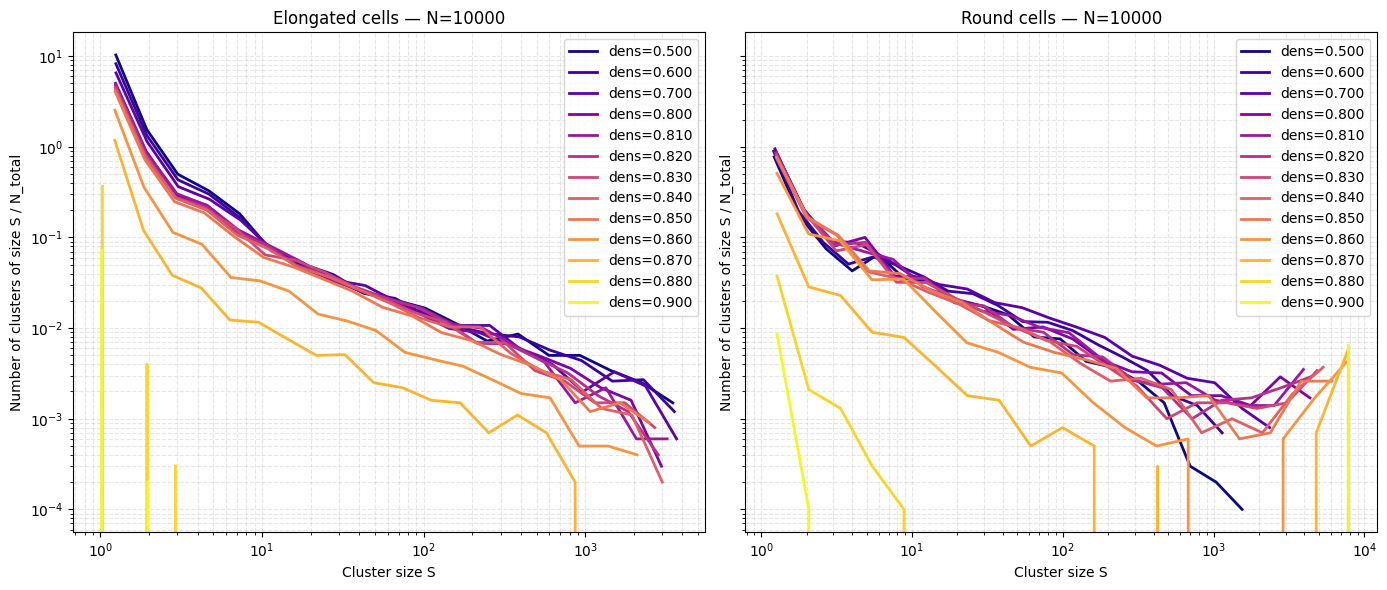

In [31]:
densities = [0.5, 0.6, 0.7, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.9]
#densities = [0.5, 0.7, 0.85, 0.9]
plot_relative_cluster_size_distribution(densities, num_cells=10_000)